# Assignment 3

Mathia Quimpo, Matthew Chin, Wanqiu Zhang

## Exploration and Preprocessing

In [4]:
!pip install --upgrade pip

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\matth\anaconda3\python.exe -m pip install --upgrade pip


In [5]:
!pip install --force-reinstall pyLDAvis==3.4.1

  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached numpy-2.2.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached numexpr-2.10.2-cp312-cp312-win_amd64.whl.metadata (8.3 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl.metadata (8.2 kB)
  Using cached setuptools-77.0.3-py3-none-any.whl.metadata (6.6 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached threadpoolct

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [6]:
!pip install pyLDAvis==3.4.1 numpy>=1.24.2 pandas>=2.0.0 funcy>=1.17 scipy>=1.8.0 joblib>=1.2.0 jinja2>=3.1.2 numexpr>=2.8.4 scikit-learn>=1.0.0 gensim>=4.3.0 setuptools

In [7]:
import pandas as pd
import numpy as np
import re
import os
import requests
import string
import nltk
import time
import matplotlib.pyplot as plt
import pyLDAvis
import seaborn as sns
import pyLDAvis.gensim_models as gensimvis
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation

C:\Users\matth\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [8]:
# Load dataset
file_path = "DisneylandReviews.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

print(df.head())

   ï»¿Review_ID  Rating Year_Month     Reviewer_Location  \
0     670772142       4     2019-4             Australia   
1     670682799       4     2019-5           Philippines   
2     670623270       4     2019-4  United Arab Emirates   
3     670607911       4     2019-4             Australia   
4     670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


In [9]:
# Display column names
print("Columns in the dataset:\n", df.columns)

Columns in the dataset:
 Index(['ï»¿Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location',
       'Review_Text', 'Branch'],
      dtype='object')


In [10]:
# Checking the unique values in the 'branch' column (if available)
print(df['Branch'].unique())

['Disneyland_HongKong' 'Disneyland_California' 'Disneyland_Paris']


In [11]:
# Get general info
print(df.info())

# Descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ï»¿Review_ID       42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB
None
       ï»¿Review_ID        Rating
count  4.265600e+04  42656.000000
mean   3.188553e+08      4.217695
std    1.657092e+08      1.063371
min    1.398724e+06      1.000000
25%    1.743274e+08      4.000000
50%    2.907583e+08      5.000000
75%    4.489579e+08      5.000000
max    6.708014e+08      5.000000
ï»¿Review_ID         0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64


In [12]:
# Display the entire review text
pd.set_option('display.max_colwidth', None)

In [177]:
# Identify the main text column
text_column = "Review_Text"

# Basic statistics on text length
df["text_length"] = df[text_column].astype(str).apply(len)

print("\nText Length Statistics:")
print(df["text_length"].describe())

# Spot-check a few reviews
print("\nSample Reviews:\n", df[text_column].sample(7, random_state=42))


Text Length Statistics:
count    42656.000000
mean       696.817540
std        831.396751
min         18.000000
25%        239.000000
50%        435.000000
75%        837.000000
max      20756.000000
Name: text_length, dtype: float64

Sample Reviews:
 31092                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Disneyland is so beautiful and large.To see all you need to stay there at least 3 days,as there is a lot of people and large quits, but it is worth it! V

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [16]:
# Filter reviews for each branch
df_cali = df[df['Branch'] == 'Disneyland_California']
df_hk = df[df['Branch'] == 'Disneyland_HongKong']
df_paris = df[df['Branch'] == 'Disneyland_Paris']

In [17]:
# Check how many rows are in each branch after filtering
print(f"California reviews: {df_cali.shape[0]}")
print(f"Hong Kong reviews: {df_hk.shape[0]}")
print(f"Paris reviews: {df_paris.shape[0]}")

California reviews: 19406
Hong Kong reviews: 9620
Paris reviews: 13630


In [18]:
# Define text cleaning function
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization and stopword removal
    return " ".join(words)

In [19]:
import nltk
nltk.download('punkt') # Download the 'punkt' data package
nltk.download('punkt_tab') # Download the 'punkt_tab' data package

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
import nltk
nltk.download('wordnet') # Download the 'wordnet' data package
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
# Clean text function applied separately to each branch
def preprocess_for_branch(df_branch):
    df_branch["cleaned_text"] = df_branch[text_column].apply(clean_text)
    return df_branch

# Apply preprocessing to each branch
df_cali = preprocess_for_branch(df_cali)
df_hk = preprocess_for_branch(df_hk)
df_paris = preprocess_for_branch(df_paris)

C:\Users\matth\AppData\Local\Temp\ipykernel_28400\209908346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_branch["cleaned_text"] = df_branch[text_column].apply(clean_text)
C:\Users\matth\AppData\Local\Temp\ipykernel_28400\209908346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_branch["cleaned_text"] = df_branch[text_column].apply(clean_text)
C:\Users\matth\AppData\Local\Temp\ipykernel_28400\209908346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [22]:
# Spot-check cleaned reviews
print("\nSample Cleaned Reviews (California):\n", df_cali["cleaned_text"].sample(5, random_state=42))
print("\nSample Cleaned Reviews (Hong Kong):\n", df_hk["cleaned_text"].sample(5, random_state=42))
print("\nSample Cleaned Reviews (Paris):\n", df_paris["cleaned_text"].sample(5, random_state=42))



Sample Cleaned Reviews (California):
 16434                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    yes disney expensive much fun everyone friendly get early skip ahead line cant wait go back
22928                                                                                                                                                                                                                                                                                                                        fun place along new adventure park next door first time ever disneyland within 

In [23]:
# Apply preprocessing to the original DataFrame
df = preprocess_for_branch(df)

# Spot-check cleaned reviews
print("\nSample Cleaned Reviews:\n", df["cleaned_text"].sample(5, random_state=42))


Sample Cleaned Reviews:
 31092                                                                                                                                                                                                      disneyland beautiful largeto see need stay least daysas lot people large quits worth good organized best holiday experience
28105    line ride long yes fast pass help little standing line hour get min ride ridiculous rd trip feel like keep getting worse longer there people less space ride go could day ive gone think ill sticking park arent busy im sure however youre young impressionable child love notice im past age stomach kind work reward ratio
1121                                                                                                                                                                                                            loved hong kong disneyland although much smaller anaheim one big queue happy atmosphere beautiful clean organise

## CountVectorizer

In [25]:
# Use CountVectorizer for Bag of Words model on each branch
count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

# For each branch, create the Bag of Words matrix
X_bow_cali = count_vectorizer.fit_transform(df_cali["cleaned_text"])
X_bow_hk = count_vectorizer.fit_transform(df_hk["cleaned_text"])
X_bow_paris = count_vectorizer.fit_transform(df_paris["cleaned_text"])

# Get feature names for each branch
feature_names_cali = count_vectorizer.get_feature_names_out()
feature_names_hk = count_vectorizer.get_feature_names_out()
feature_names_paris = count_vectorizer.get_feature_names_out()

# Display shape of the BoW matrix for each branch
print(f"\nBag of Words Matrix Shape (California): {X_bow_cali.shape}")
print(f"Bag of Words Matrix Shape (Hong Kong): {X_bow_hk.shape}")
print(f"Bag of Words Matrix Shape (Paris): {X_bow_paris.shape}")


Bag of Words Matrix Shape (California): (19406, 10000)
Bag of Words Matrix Shape (Hong Kong): (9620, 10000)
Bag of Words Matrix Shape (Paris): (13630, 10000)


In [26]:
# Function to prepare corpus and dictionary
def prepare_corpus(df_branch):
    tokenized_texts = [text.split() for text in df_branch["cleaned_text"]]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    return corpus, dictionary

# Prepare corpus and dictionary for each branch
corpus_cali, dictionary_cali = prepare_corpus(df_cali)
corpus_hk, dictionary_hk = prepare_corpus(df_hk)
corpus_paris, dictionary_paris = prepare_corpus(df_paris)

## LDA

In [28]:
# Train LDA Model
def train_lda(corpus, dictionary, num_topics=7):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                         random_state=42, passes=15, iterations=500, alpha='auto')
    return lda_model

# Train LDA for each branch
lda_model_cali = train_lda(corpus_cali, dictionary_cali, num_topics=7)
lda_model_hk = train_lda(corpus_hk, dictionary_hk, num_topics=7)
lda_model_paris = train_lda(corpus_paris, dictionary_paris, num_topics=7)

In [29]:
# Compute Coherence Score
def compute_coherence(lda_model, tokenized_texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Compute coherence for each branch
coherence_cali = compute_coherence(lda_model_cali, [text.split() for text in df_cali["cleaned_text"]], dictionary_cali)
coherence_hk = compute_coherence(lda_model_hk, [text.split() for text in df_hk["cleaned_text"]], dictionary_hk)
coherence_paris = compute_coherence(lda_model_paris, [text.split() for text in df_paris["cleaned_text"]], dictionary_paris)

print(f'Coherence Score (California): {coherence_cali:.4f}')
print(f'Coherence Score (Hong Kong): {coherence_hk:.4f}')
print(f'Coherence Score (Paris): {coherence_paris:.4f}')

Coherence Score (California): 0.4793
Coherence Score (Hong Kong): 0.4717
Coherence Score (Paris): 0.4589


In [30]:
# Compute Perplexity Score
perplexity_cali = lda_model_cali.log_perplexity(corpus_cali)
perplexity_hk = lda_model_hk.log_perplexity(corpus_hk)
perplexity_paris = lda_model_paris.log_perplexity(corpus_paris)

print(f'Perplexity Score (California): {np.exp(perplexity_cali):.4f}')
print(f'Perplexity Score (Hong Kong): {np.exp(perplexity_hk):.4f}')
print(f'Perplexity Score (Paris): {np.exp(perplexity_paris):.4f}')

Perplexity Score (California): 0.0007
Perplexity Score (Hong Kong): 0.0007
Perplexity Score (Paris): 0.0006


In [31]:
# Visualize for California
pyLDAvis.enable_notebook()
lda_vis_cali = gensimvis.prepare(lda_model_cali, corpus_cali, dictionary_cali)
pyLDAvis.display(lda_vis_cali)

In [32]:
# Visualize for Hong Kong
lda_vis_hk = gensimvis.prepare(lda_model_hk, corpus_hk, dictionary_hk)
pyLDAvis.display(lda_vis_hk)

In [33]:
# Visualize for Paris
lda_vis_paris = gensimvis.prepare(lda_model_paris, corpus_paris, dictionary_paris)
pyLDAvis.display(lda_vis_paris)

C:\Users\matth\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\matth\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\matth\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


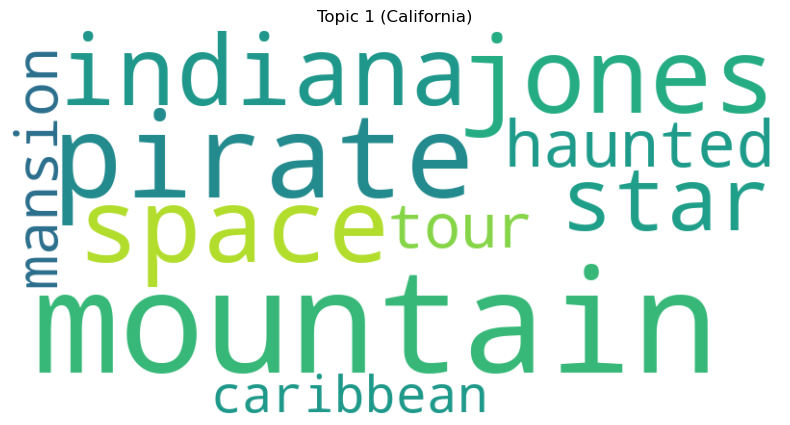

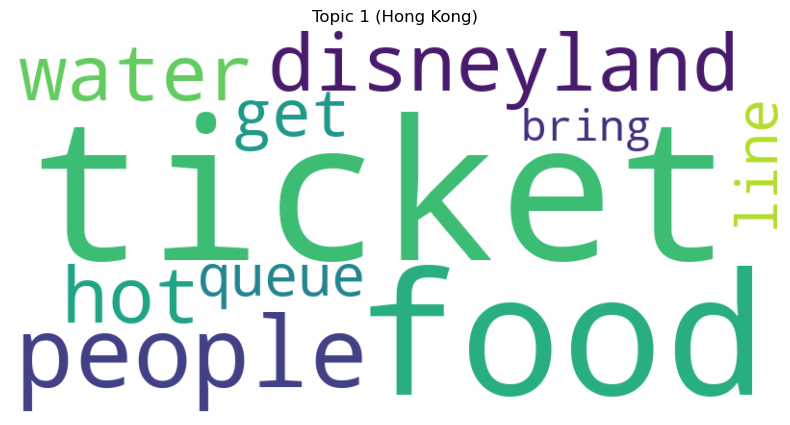

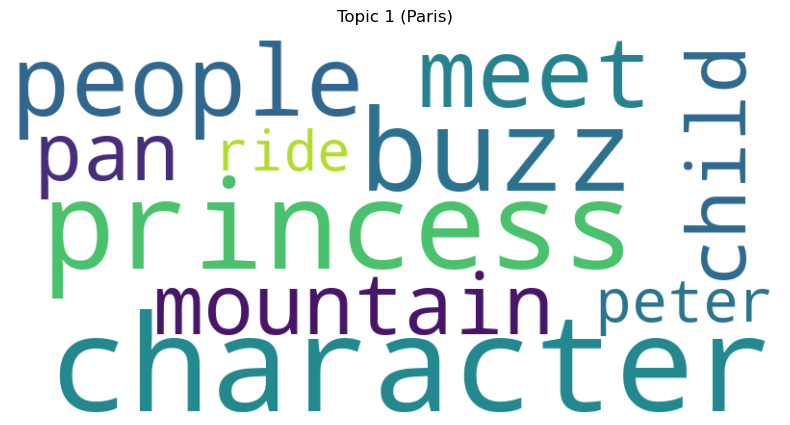

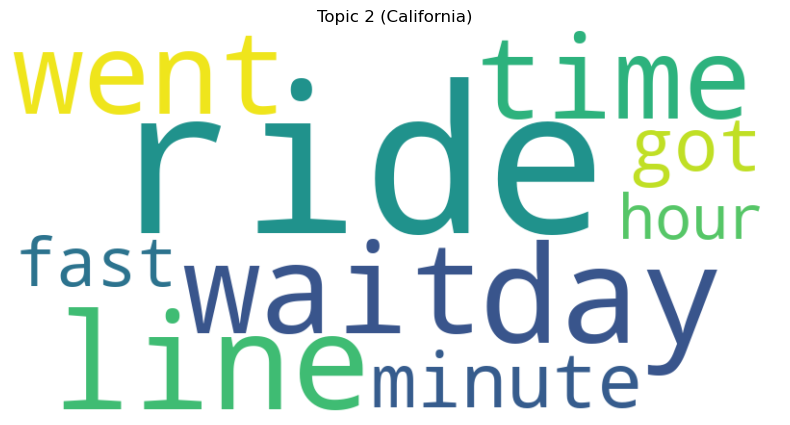

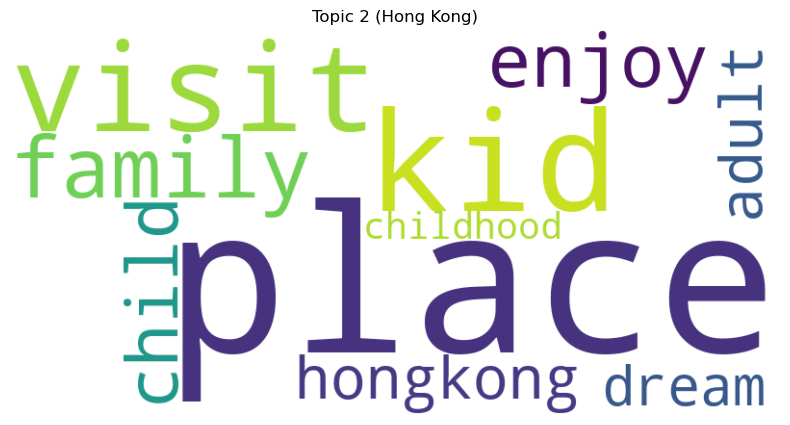

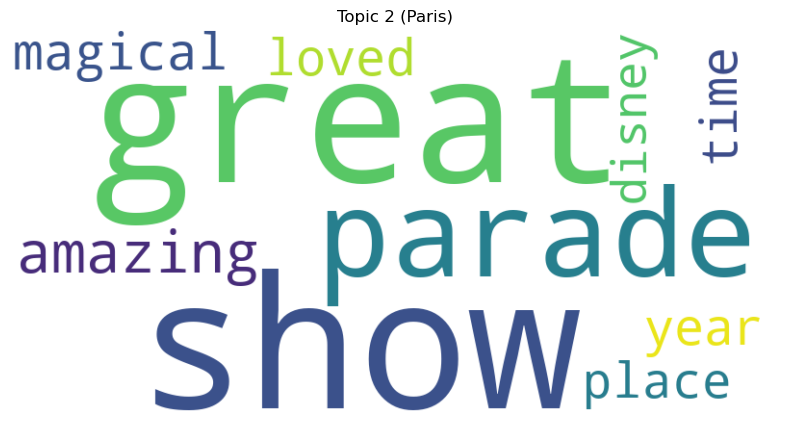

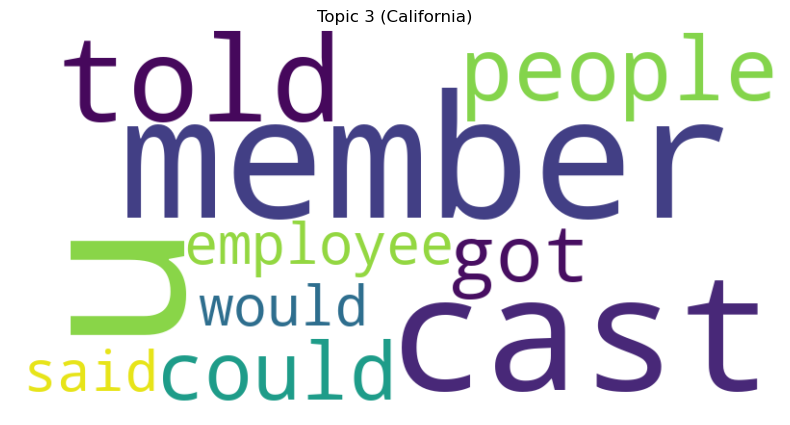

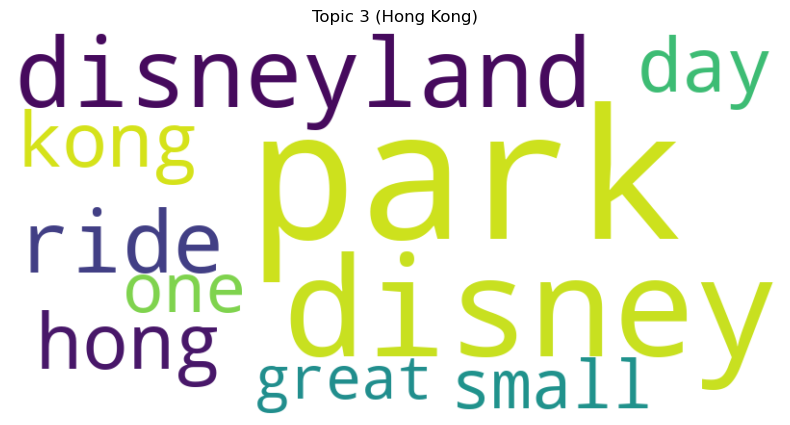

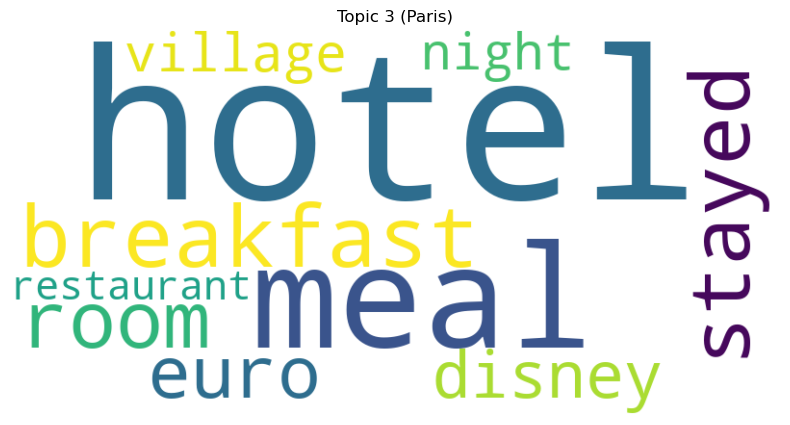

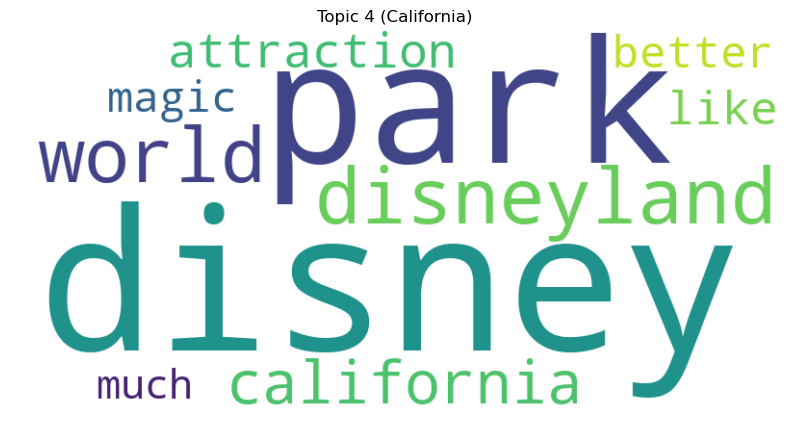

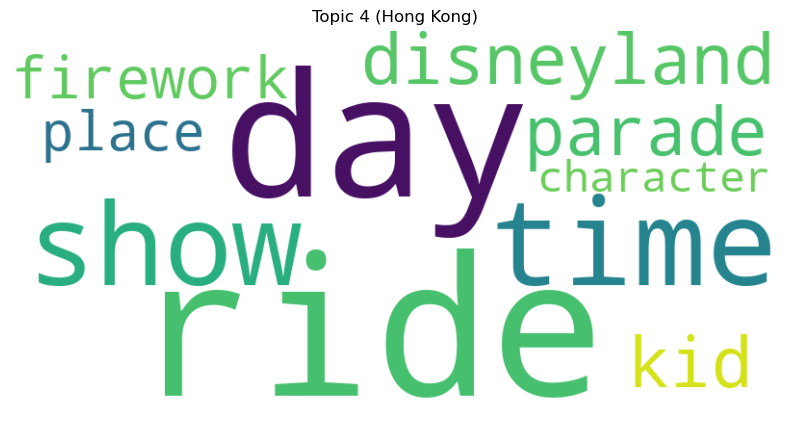

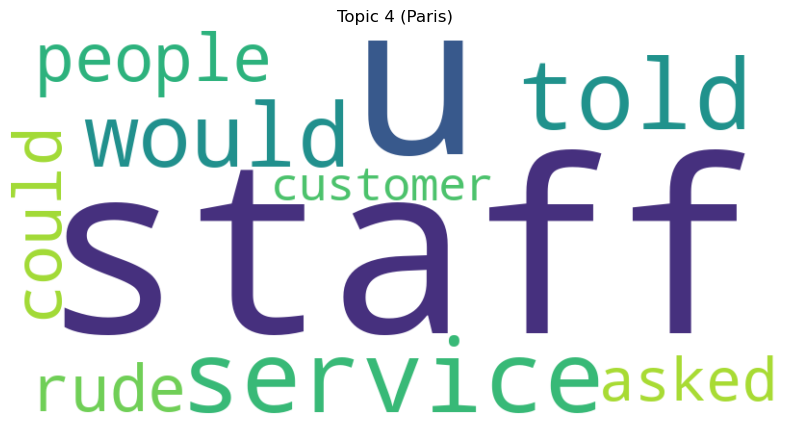

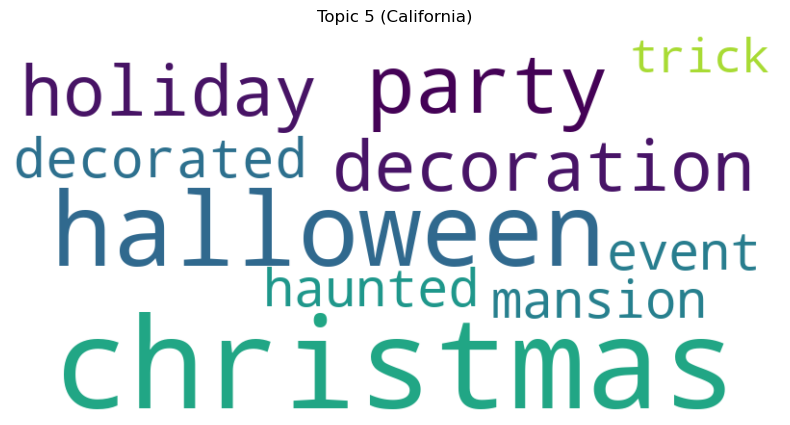

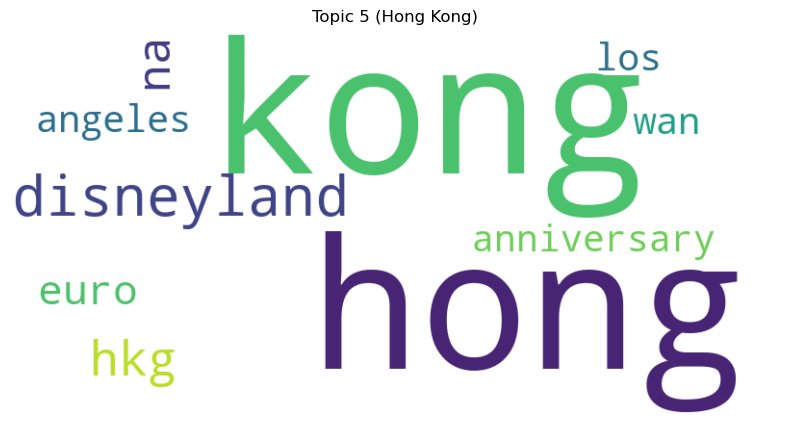

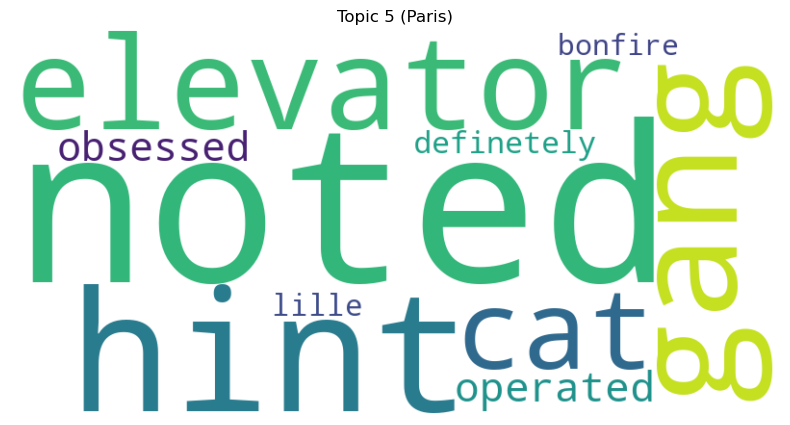

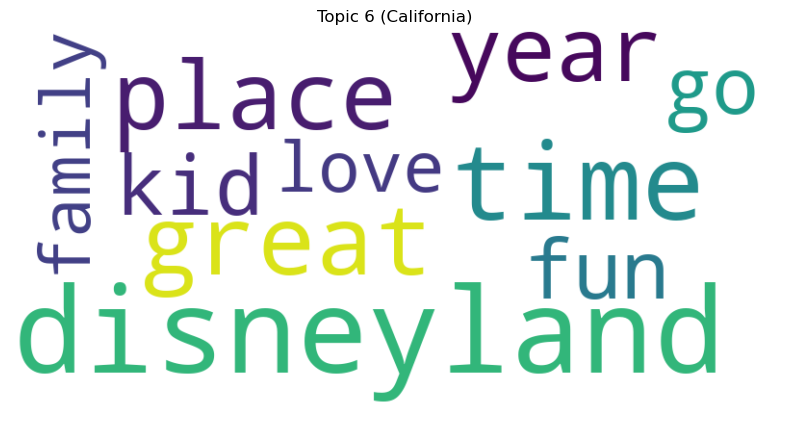

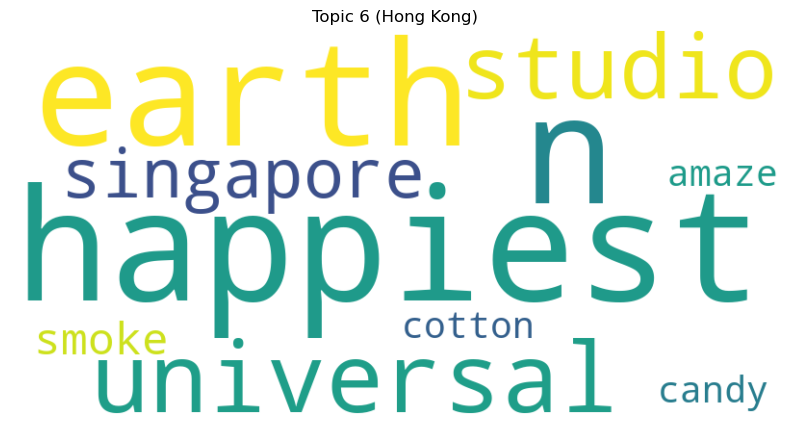

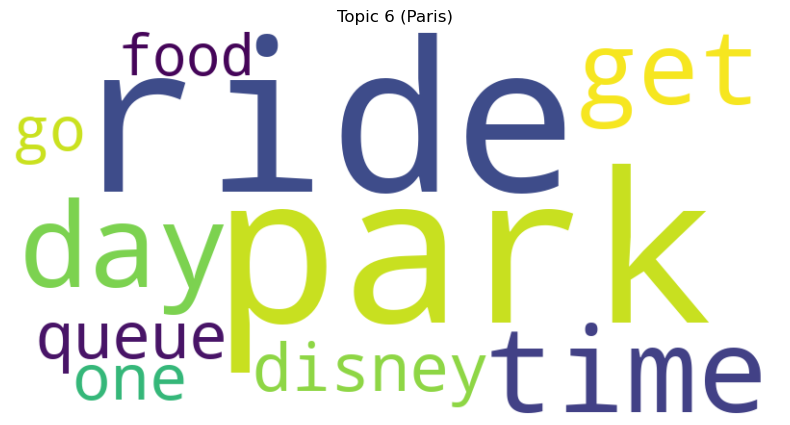

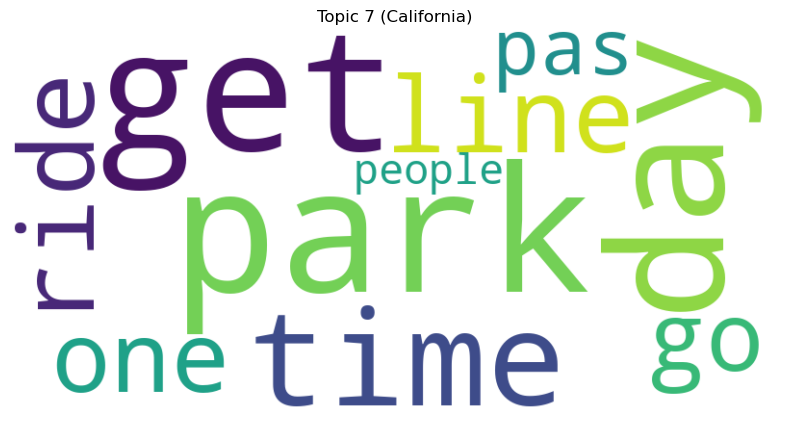

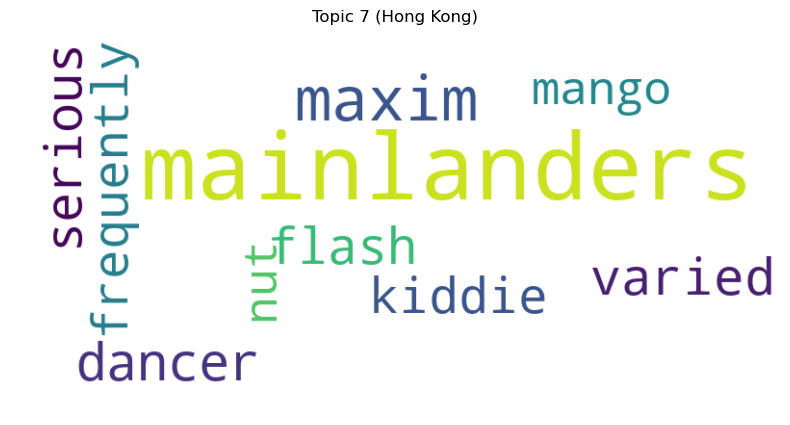

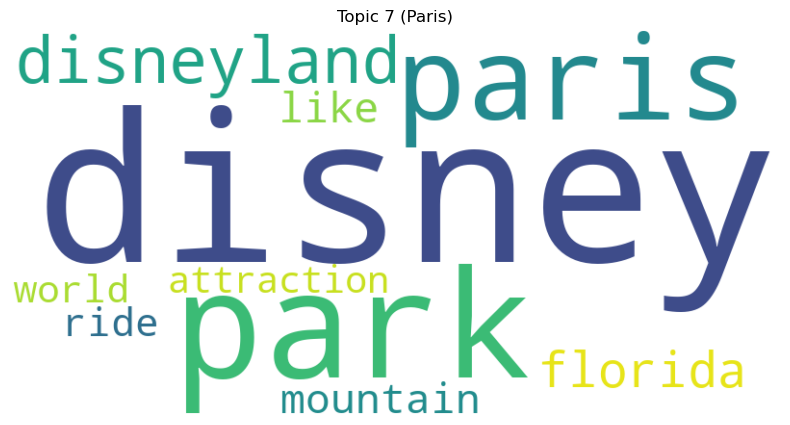

In [34]:
# Generate Word Clouds for Each Topic (you can adjust number of topics as needed)
lda_topic_words_cali = {}
lda_topic_words_hk = {}
lda_topic_words_paris = {}

for topic in range(7):  # Adjust the range to the number of topics
    words_cali = dict(lda_model_cali.show_topic(topic, 10))  # Top 10 words for each topic in California
    words_hk = dict(lda_model_hk.show_topic(topic, 10))  # Top 10 words for each topic in Hong Kong
    words_paris = dict(lda_model_paris.show_topic(topic, 10))  # Top 10 words for each topic in Paris

    lda_topic_words_cali[f"Topic {topic+1}"] = list(words_cali.keys())
    lda_topic_words_hk[f"Topic {topic+1}"] = list(words_hk.keys())
    lda_topic_words_paris[f"Topic {topic+1}"] = list(words_paris.keys())

    # Generate Word Cloud for each topic in California
    wordcloud_cali = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_cali)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_cali, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (California)")
    plt.show()

    # Generate Word Cloud for each topic in Hong Kong
    wordcloud_hk = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_hk)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_hk, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (Hong Kong)")
    plt.show()

    # Generate Word Cloud for each topic in Paris
    wordcloud_paris = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_paris)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_paris, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (Paris)")
    plt.show()

In [35]:
# Print the top words for each topic (for example, the top 10 words)
num_words = 10

# Print topics for each branch
topics_cali = lda_model_cali.print_topics(num_words=num_words)
topics_hk = lda_model_hk.print_topics(num_words=num_words)
topics_paris = lda_model_paris.print_topics(num_words=num_words)

print("Topics for California:")
for topic in topics_cali:
    print(f"Topic {topic[0]}: {topic[1]}")

print("\nTopics for Hong Kong:")
for topic in topics_hk:
    print(f"Topic {topic[0]}: {topic[1]}")

print("\nTopics for Paris:")
for topic in topics_paris:
    print(f"Topic {topic[0]}: {topic[1]}")

Topics for California:
Topic 0: 0.086*"mountain" + 0.055*"pirate" + 0.046*"jones" + 0.045*"space" + 0.044*"indiana" + 0.035*"star" + 0.035*"haunted" + 0.031*"tour" + 0.028*"mansion" + 0.027*"caribbean"
Topic 1: 0.081*"ride" + 0.026*"day" + 0.025*"line" + 0.023*"wait" + 0.021*"time" + 0.020*"went" + 0.017*"minute" + 0.016*"got" + 0.013*"fast" + 0.011*"hour"
Topic 2: 0.019*"u" + 0.012*"member" + 0.010*"cast" + 0.009*"told" + 0.008*"people" + 0.007*"could" + 0.006*"got" + 0.006*"employee" + 0.006*"said" + 0.006*"would"
Topic 3: 0.058*"disney" + 0.043*"park" + 0.025*"disneyland" + 0.025*"world" + 0.014*"california" + 0.013*"attraction" + 0.012*"like" + 0.011*"better" + 0.010*"magic" + 0.009*"much"
Topic 4: 0.091*"christmas" + 0.056*"halloween" + 0.033*"party" + 0.025*"decoration" + 0.024*"holiday" + 0.013*"decorated" + 0.012*"mansion" + 0.012*"haunted" + 0.012*"event" + 0.010*"trick"
Topic 5: 0.038*"disneyland" + 0.030*"time" + 0.025*"great" + 0.024*"place" + 0.021*"year" + 0.017*"kid" + 0

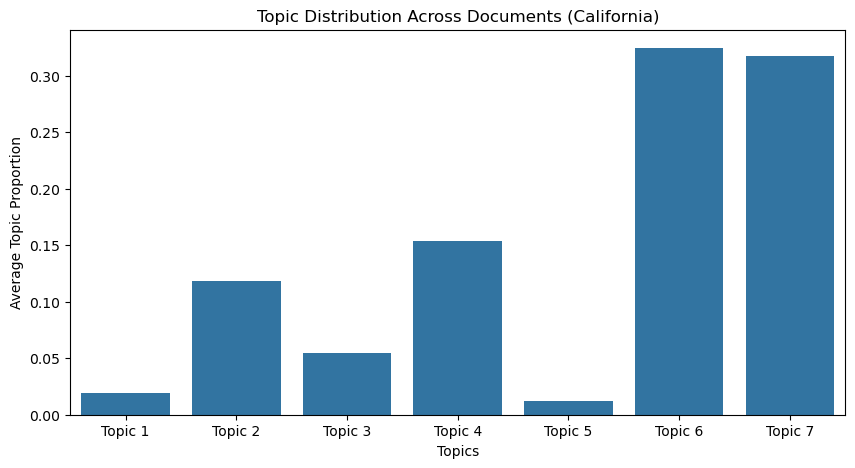

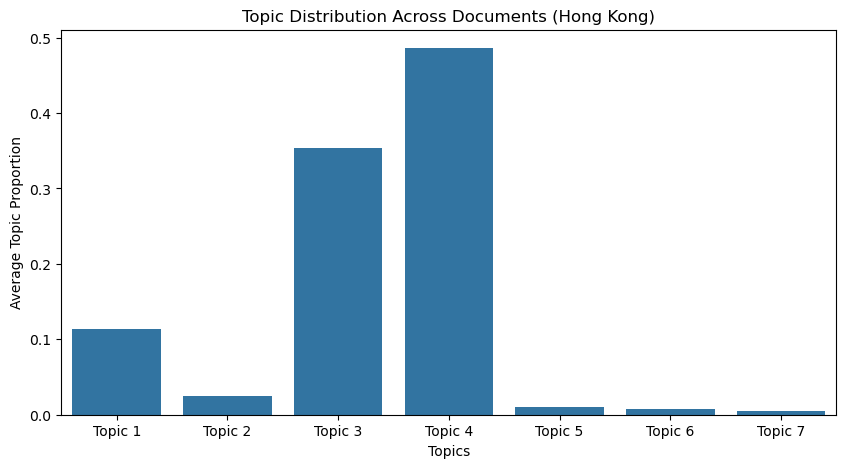

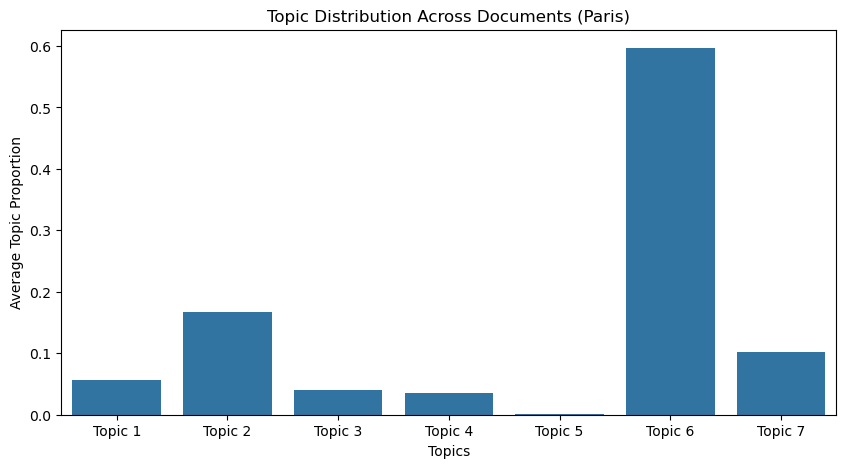

In [36]:
# Visualize Topic Distribution
def plot_topic_distributions(lda_model, corpus, branch_name):
    topic_proportions = np.array([lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus])
    topic_proportions = np.array([[prob for _, prob in doc] for doc in topic_proportions])
    avg_topic_proportions = topic_proportions.mean(axis=0)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=[f'Topic {i+1}' for i in range(len(avg_topic_proportions))], y=avg_topic_proportions)
    plt.xlabel("Topics")
    plt.ylabel("Average Topic Proportion")
    plt.title(f"Topic Distribution Across Documents ({branch_name})")
    plt.show()

# Plot topic distribution for each branch
plot_topic_distributions(lda_model_cali, corpus_cali, "California")
plot_topic_distributions(lda_model_hk, corpus_hk, "Hong Kong")
plot_topic_distributions(lda_model_paris, corpus_paris, "Paris")

In [37]:
# Function to get topic distribution for each document
def get_topic_distribution(lda_model, corpus):
    topic_distributions = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
        topic_dist_dict = dict(topic_dist)
        for i in range(lda_model.num_topics):
            if i not in topic_dist_dict:
                topic_dist_dict[i] = 0
        topic_distributions.append(topic_dist_dict)

    # Create a DataFrame
    df_topic_distributions = pd.DataFrame(topic_distributions)
    df_topic_distributions = df_topic_distributions.reindex(sorted(df_topic_distributions.columns), axis=1)
    return df_topic_distributions

# Example usage (assuming lda_model and corpus are already defined for each branch):
topic_distribution_cali = get_topic_distribution(lda_model_cali, corpus_cali)
topic_distribution_hk = get_topic_distribution(lda_model_hk, corpus_hk)
topic_distribution_paris = get_topic_distribution(lda_model_paris, corpus_paris)

topic_distribution_cali, topic_distribution_hk, topic_distribution_paris

(              0         1         2         3         4         5         6
 0      0.004118  0.029775  0.012837  0.118092  0.003483  0.604660  0.227034
 1      0.003076  0.031258  0.011141  0.088652  0.002601  0.177774  0.685499
 2      0.003226  0.197093  0.010348  0.133706  0.061395  0.188996  0.405236
 3      0.023007  0.361160  0.004743  0.360355  0.001210  0.150327  0.099198
 4      0.005697  0.122152  0.019482  0.124604  0.004817  0.394195  0.329053
 ...         ...       ...       ...       ...       ...       ...       ...
 19401  0.001109  0.142757  0.004483  0.102370  0.011049  0.358999  0.379234
 19402  0.005464  0.106338  0.016660  0.081093  0.004620  0.299204  0.486621
 19403  0.001341  0.260570  0.157847  0.038273  0.017805  0.125594  0.398569
 19404  0.005250  0.088210  0.016042  0.112844  0.004439  0.558176  0.215039
 19405  0.071267  0.169460  0.025722  0.093106  0.004198  0.210604  0.425644
 
 [19406 rows x 7 columns],
              0         1         2         3  

## NMF


In [39]:
from gensim.models.nmf import Nmf

In [40]:
# Train NMF Model
def train_nmf(corpus, dictionary, num_topics=7):
    """
    Trains a Gensim-based NMF model on the provided corpus and dictionary.

    :param corpus: Gensim corpus (list of (token_id, token_count) tuples).
    :param dictionary: Gensim dictionary mapping token_id -> token_string.
    :param num_topics: Number of topics for the NMF model.
    :return: Trained Nmf model.
    """
    nmf_model = Nmf(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=15,       # Number of passes through the corpus
        w_max_iter=200,  # Max iterations for the W matrix
        h_max_iter=200   # Max iterations for the H matrix
    )
    return nmf_model

In [41]:
# Example usage for each branch (assuming you have created corpus_cali, dictionary_cali, etc.)
nmf_model_cali = train_nmf(corpus_cali, dictionary_cali, num_topics=7)
nmf_model_hk = train_nmf(corpus_hk, dictionary_hk, num_topics=7)
nmf_model_paris = train_nmf(corpus_paris, dictionary_paris, num_topics=7)

C:\Users\matth\anaconda3\Lib\site-packages\gensim\models\nmf.py:578: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\Users\matth\anaconda3\Lib\site-packages\gensim\models\nmf.py:607: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\Users\matth\anaconda3\Lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\Users\matth\anaconda3\Lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please import `csc_matrix` from the `scipy.spar

In [42]:
from gensim.models import CoherenceModel

# Compute Coherence Score for an NMF model
def compute_coherence_nmf(nmf_model, tokenized_texts, dictionary):
    coherence_model = CoherenceModel(model=nmf_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Compute coherence for each branch using the cleaned tokenized texts
# Assuming your cleaned texts are stored in a column "cleaned_text" and are space-separated tokens.
coherence_nmf_cali = compute_coherence_nmf(nmf_model_cali, [text.split() for text in df_cali["cleaned_text"]], dictionary_cali)
coherence_nmf_hk = compute_coherence_nmf(nmf_model_hk, [text.split() for text in df_hk["cleaned_text"]], dictionary_hk)
coherence_nmf_paris = compute_coherence_nmf(nmf_model_paris, [text.split() for text in df_paris["cleaned_text"]], dictionary_paris)

print(f'Coherence Score (NMF - California): {coherence_nmf_cali:.4f}')
print(f'Coherence Score (NMF - Hong Kong): {coherence_nmf_hk:.4f}')
print(f'Coherence Score (NMF - Paris): {coherence_nmf_paris:.4f}')

Coherence Score (NMF - California): 0.3571
Coherence Score (NMF - Hong Kong): 0.3342
Coherence Score (NMF - Paris): 0.3273


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF # Import NMF

file_path = "DisneylandReviews.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

print(df.head())

print("Columns in the dataset:", df.columns)

# Assume that the review text is stored in a column named "Review_Text".
# If your column has a different name, change it here.
if 'Review_Text' in df.columns:  # Changed 'Review' to 'Review_Text'
    reviews = df['Review_Text'].dropna().astype(str) # Added .astype(str)
else:
    print("Column 'Review_Text' not found. Please adjust the column name accordingly.")
    # For instance, if the reviews are in the first column, you could use:
    reviews = df.iloc[:, 0].dropna().astype(str)  # Added .astype(str)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(reviews)

# Choose the number of topics you want to extract (e.g., 5 topics)
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42) # Now NMF is defined
W = nmf_model.fit_transform(tfidf)  # Document-topic matrix
H = nmf_model.components_           # Topic-word matrix

   ï»¿Review_ID  Rating Year_Month     Reviewer_Location  \
0     670772142       4     2019-4             Australia   
1     670682799       4     2019-5           Philippines   
2     670623270       4     2019-4  United Arab Emirates   
3     670607911       4     2019-4             Australia   
4     670607296       4     2019-4        United Kingdom   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

C:\Users\matth\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

In [45]:
from sklearn.decomposition import NMF

#Train the NMF Model
num_topics = 7  # adjust the number of topics as needed
nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

In [46]:
#Compute the "Perplexity" via Reconstruction Error
#The reconstruction error is available directly from the model:
reconstruction_error = nmf_model.reconstruction_err_
print(f"Reconstruction Error (proxy for perplexity): {reconstruction_error:.4f}")

# Alternatively, compute it manually:
reconstructed_matrix = np.dot(W, H)
manual_error = np.linalg.norm(tfidf_matrix - reconstructed_matrix, ord='fro')
print(f"Manual Reconstruction Error: {manual_error:.4f}")

Reconstruction Error (proxy for perplexity): 197.3149
Manual Reconstruction Error: 197.3149


In [47]:
import numpy as np

doc_topic_dist = nmf_model_cali[corpus_cali]

# Convert to dense array with consistent shape, padding with zeros for missing topics
num_topics = nmf_model_cali.num_topics
doc_topic_dist_dense = np.zeros((len(corpus_cali), num_topics))

for doc_idx, doc_topics in enumerate(doc_topic_dist):
    for topic_idx, prob in doc_topics:
        doc_topic_dist_dense[doc_idx, topic_idx] = prob

# Now you can use 'doc_topic_dist_dense' for pyLDAvis or other operations

In [49]:
#visualize for Paris
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# -------------------------
# 1. Convert Document-Topic Distributions to a Dense Matrix
# -------------------------
# Retrieve the topic distribution for each document in the Paris branch.
doc_topic_dist = nmf_model_paris[corpus_paris]

num_topics = nmf_model_paris.num_topics
doc_topic_dist_dense = np.zeros((len(corpus_paris), num_topics))

for doc_idx, doc_topics in enumerate(doc_topic_dist):
    for topic_idx, prob in doc_topics:  # each doc_topics is a list of (topic_id, probability)
        doc_topic_dist_dense[doc_idx, topic_idx] = prob

# Normalize rows so that each document's topic distribution sums to 1
doc_topic_dist_dense = doc_topic_dist_dense / doc_topic_dist_dense.sum(axis=1, keepdims=True)

# -------------------------
# 2. Obtain the Topic-Term Matrix
# -------------------------
# For a Gensim NMF model, you can use get_topics() to get the topic-term matrix.
topic_term_matrix = nmf_model_paris.get_topics()
# Normalize each topic (row) to sum to 1.
topic_term_matrix = topic_term_matrix / topic_term_matrix.sum(axis=1, keepdims=True)

# -------------------------
# 3. Compute Term Frequencies and Document Lengths
# -------------------------
# Build a list of document lengths and overall term frequencies from the corpus.
vocab = list(dictionary_paris.values())
term_frequency = np.zeros(len(vocab))
doc_lengths = []

for doc in corpus_paris:
    doc_len = 0
    for term_id, count in doc:
        term_frequency[term_id] += count
        doc_len += count
    doc_lengths.append(doc_len)

# -------------------------
# 4. Prepare and Display the Visualization for Paris
# -------------------------
nmf_vis_paris = pyLDAvis.prepare(
    topic_term_dists=topic_term_matrix,
    doc_topic_dists=doc_topic_dist_dense,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

pyLDAvis.display(nmf_vis_paris)


C:\Users\matth\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\matth\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\matth\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [51]:
#visualize for California
import numpy as np

doc_topic_dist = nmf_model_cali[corpus_cali]

# Convert to dense array with consistent shape, padding with zeros for missing topics
num_topics = nmf_model_cali.num_topics
doc_topic_dist_dense = np.zeros((len(corpus_cali), num_topics))

for doc_idx, doc_topics in enumerate(doc_topic_dist):
    for topic_idx, prob in doc_topics:  # Assuming doc_topics is a list of (topic_id, probability) tuples
        doc_topic_dist_dense[doc_idx, topic_idx] = prob

# Normalize each row (document) to sum to 1
doc_topic_dist_dense = doc_topic_dist_dense / doc_topic_dist_dense.sum(axis=1, keepdims=True)

# Now you can use 'doc_topic_dist_dense' for pyLDAvis or other operations
nmf_vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_matrix,
    doc_topic_dists=doc_topic_dist_dense,  # Use the dense document-topic distribution
    doc_lengths=[len(doc) for doc in corpus_cali],
    vocab=list(dictionary_cali.values()),
    term_frequency=term_frequency
)

# Display the interactive visualization
pyLDAvis.display(nmf_vis_data)

ValidationError: 
 * Number of terms in vocabulary does not match the number of columns of topic_term_dists (where each row of topic_term_dists is a probability distribution of terms for a given topic)
 * Length of term_frequency not equal to the number of terms in the number of terms in the vocabulary (len of vocab)

In [ ]:
#visualize for Hong Kong
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# -------------------------
# 1. Compute Document-Topic Distributions for Hong Kong
# -------------------------
doc_topic_dist = nmf_model_hk[corpus_hk]
num_topics = nmf_model_hk.num_topics
doc_topic_dist_dense = np.zeros((len(corpus_hk), num_topics))

# Convert the sparse representation to a dense matrix.
for doc_idx, doc_topics in enumerate(doc_topic_dist):
    for topic_idx, prob in doc_topics:
        doc_topic_dist_dense[doc_idx, topic_idx] = prob

# Normalize each document's topic distribution so the rows sum to 1.
doc_topic_dist_dense = doc_topic_dist_dense / doc_topic_dist_dense.sum(axis=1, keepdims=True)

# -------------------------
# 2. Compute the Topic-Term Matrix for Hong Kong
# -------------------------
# Assuming the NMF model provides a get_topics() method.
topic_term_matrix = nmf_model_hk.get_topics()
# Normalize each topic row to form a probability distribution over the vocabulary.
topic_term_matrix = topic_term_matrix / topic_term_matrix.sum(axis=1, keepdims=True)

# -------------------------
# 3. Compute Term Frequencies and Document Lengths
# -------------------------
vocab = list(dictionary_hk.values())
term_frequency = np.zeros(len(vocab))
doc_lengths = []

for doc in corpus_hk:
    doc_len = 0
    for term_id, count in doc:
        term_frequency[term_id] += count
        doc_len += count
    doc_lengths.append(doc_len)

# -------------------------
# 4. Prepare and Display the Visualization for Hong Kong
# -------------------------
nmf_vis_hk = pyLDAvis.prepare(
    topic_term_dists=topic_term_matrix,
    doc_topic_dists=doc_topic_dist_dense,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

pyLDAvis.display(nmf_vis_hk)


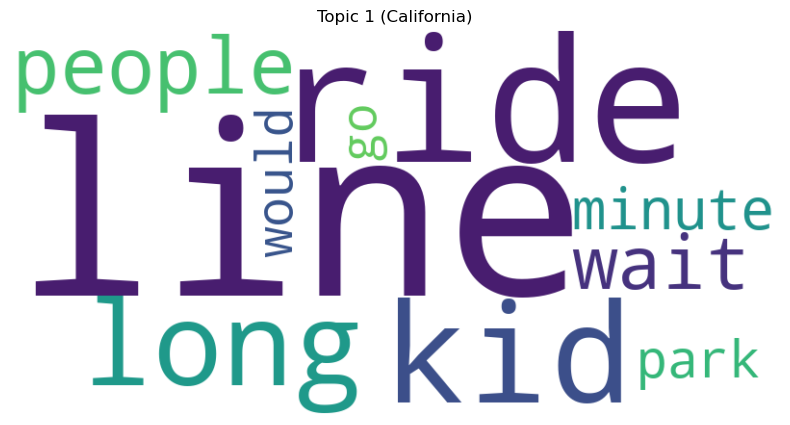

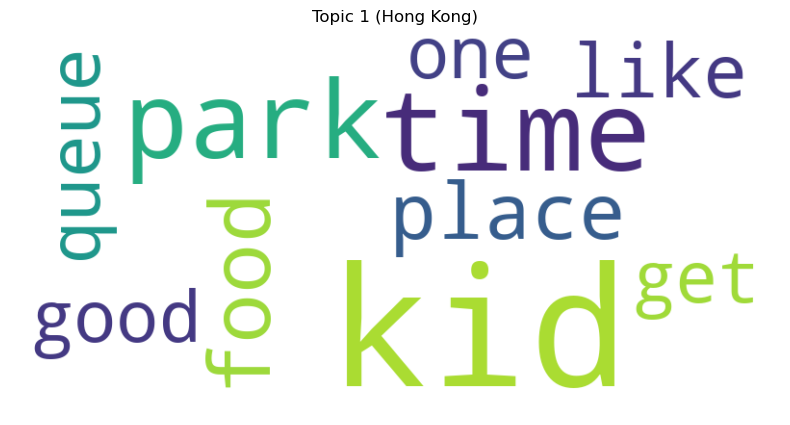

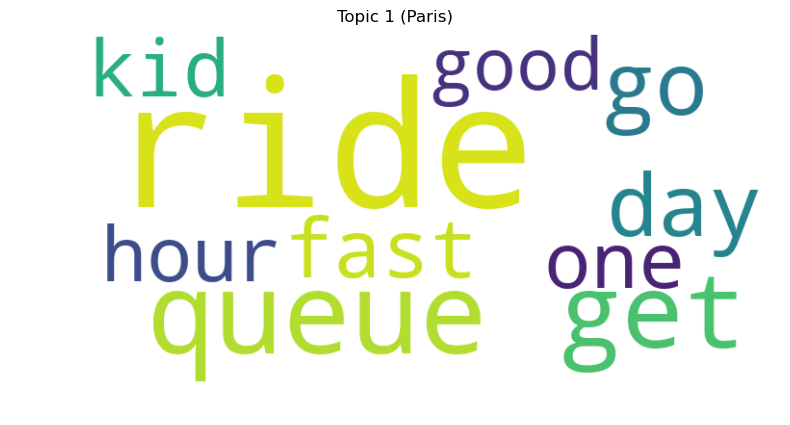

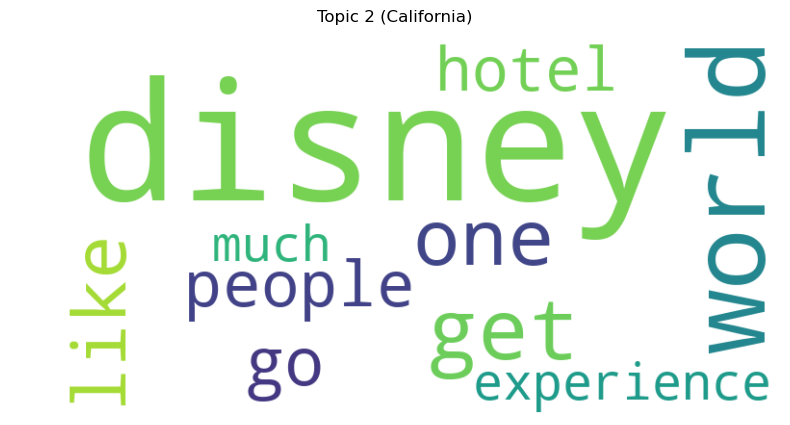

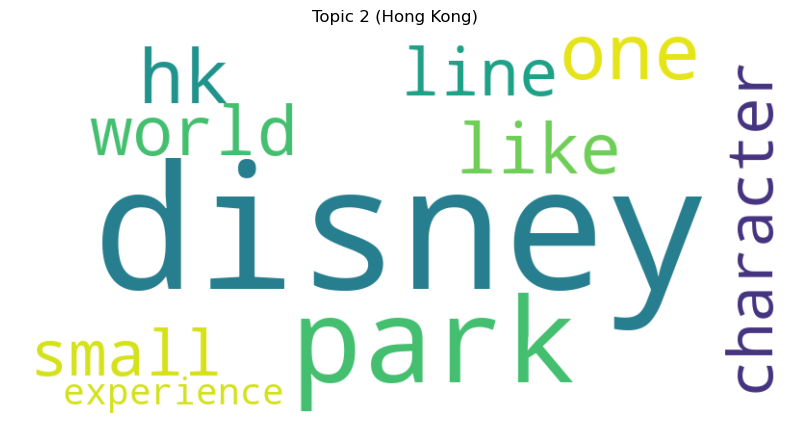

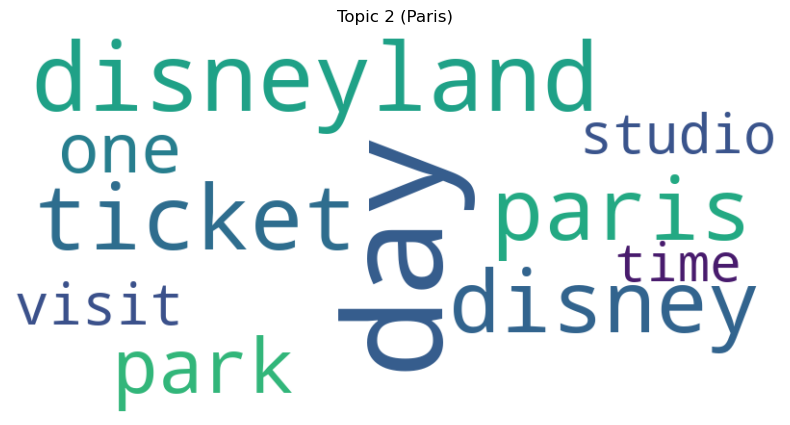

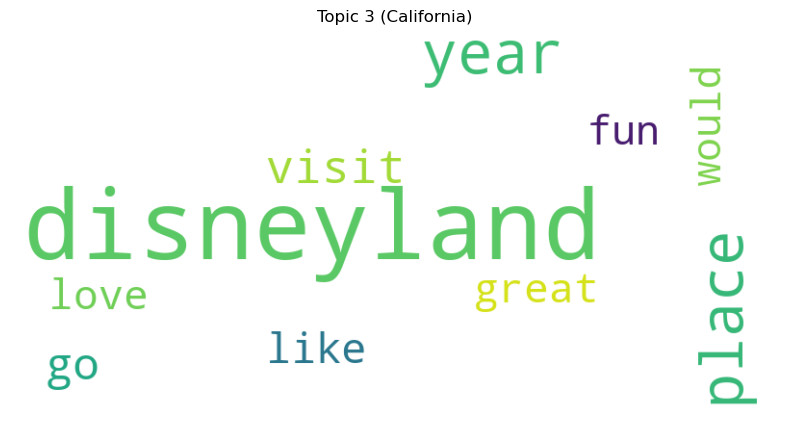

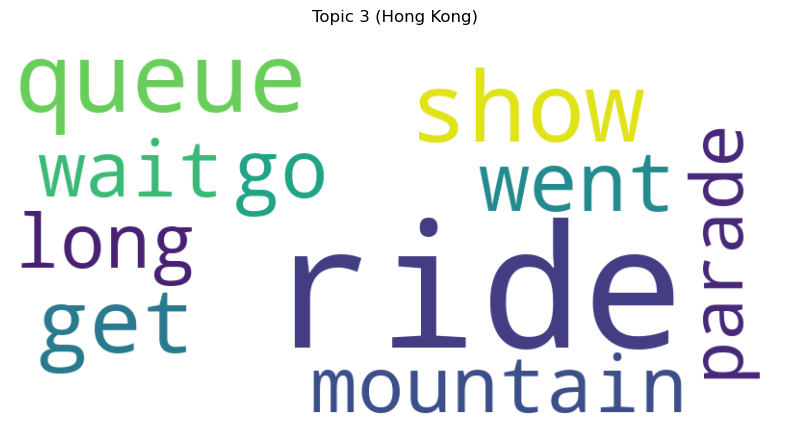

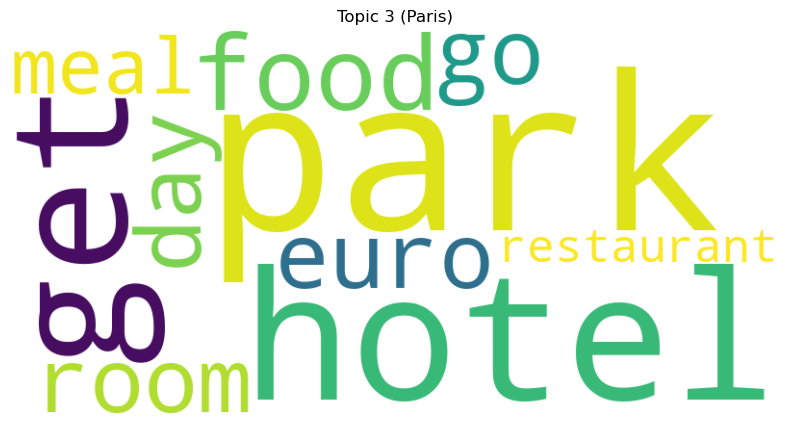

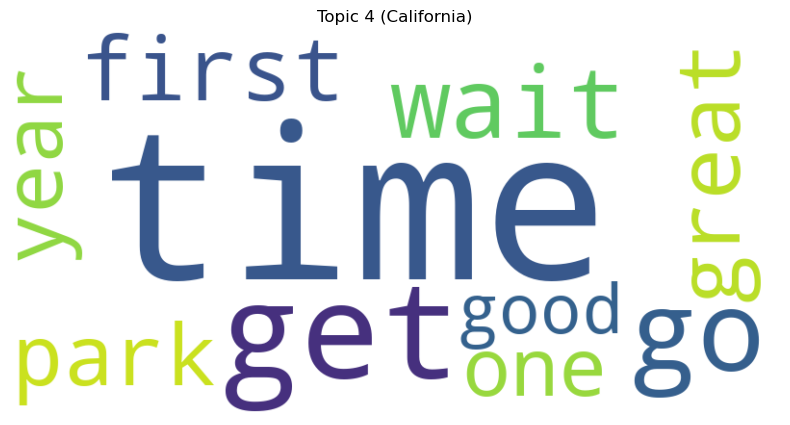

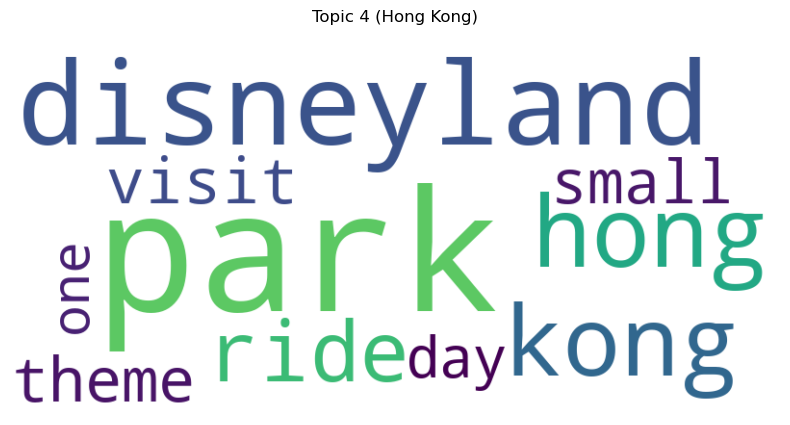

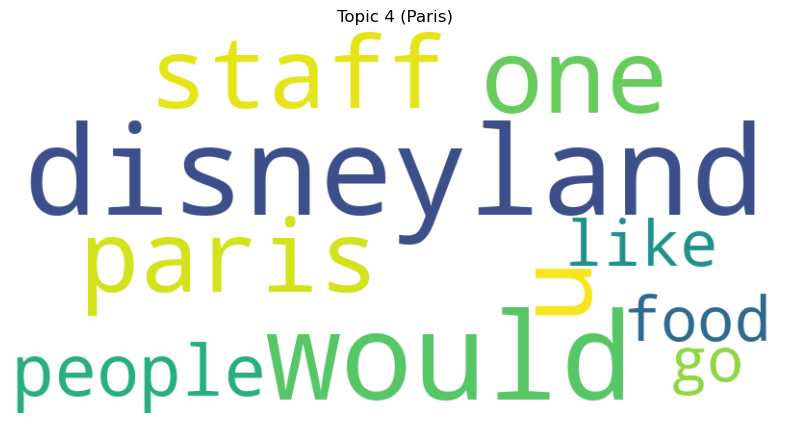

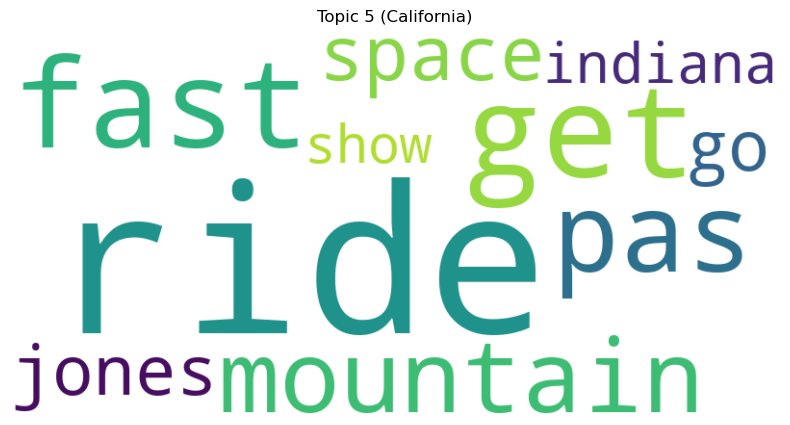

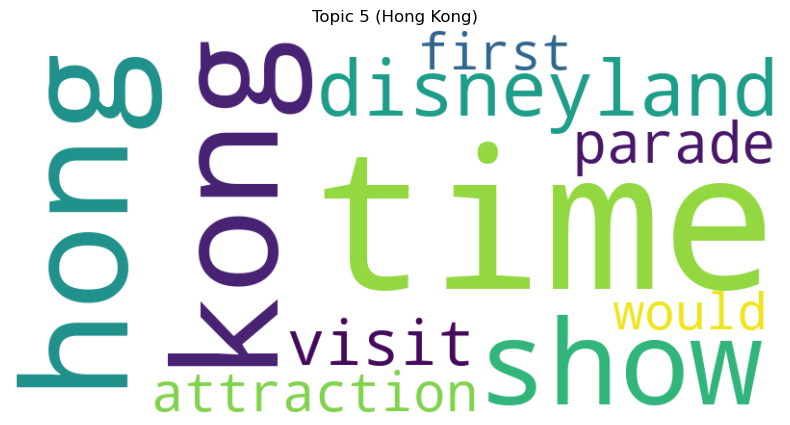

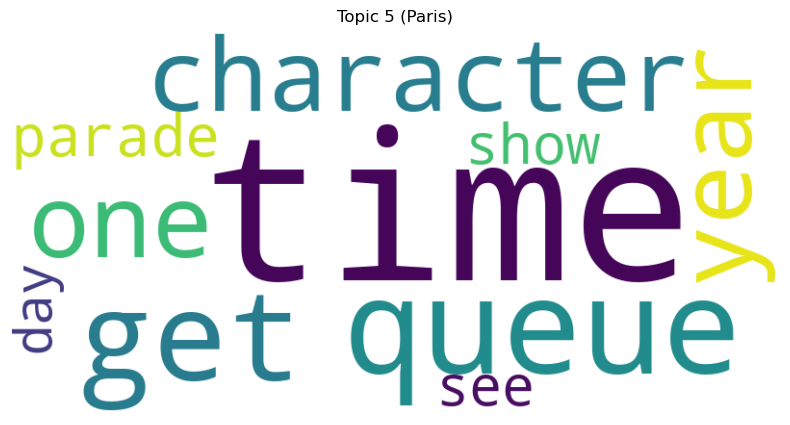

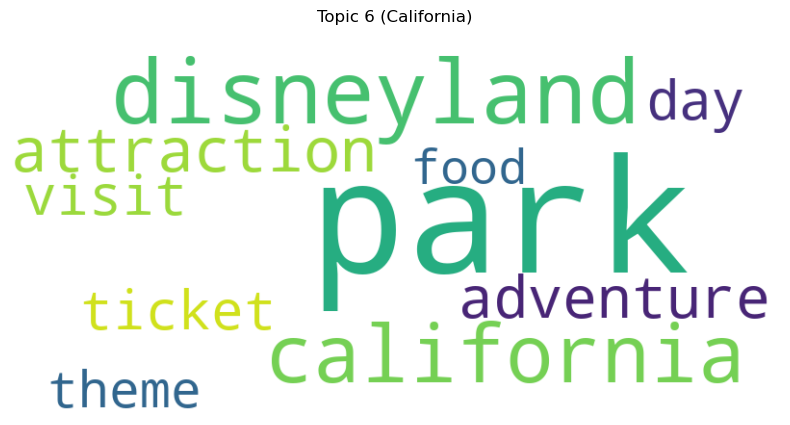

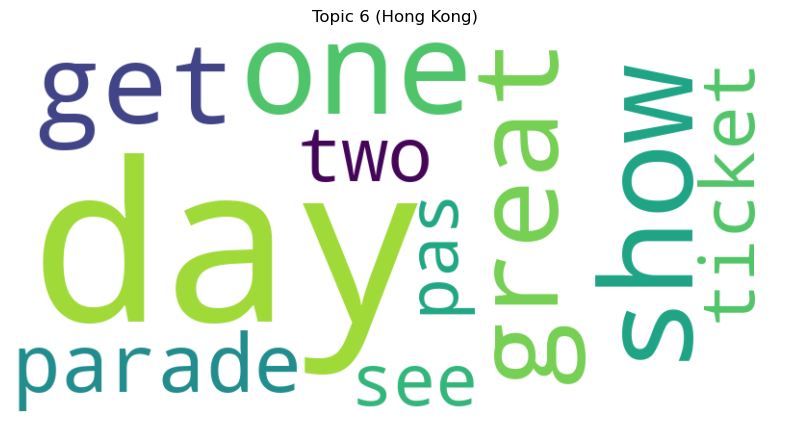

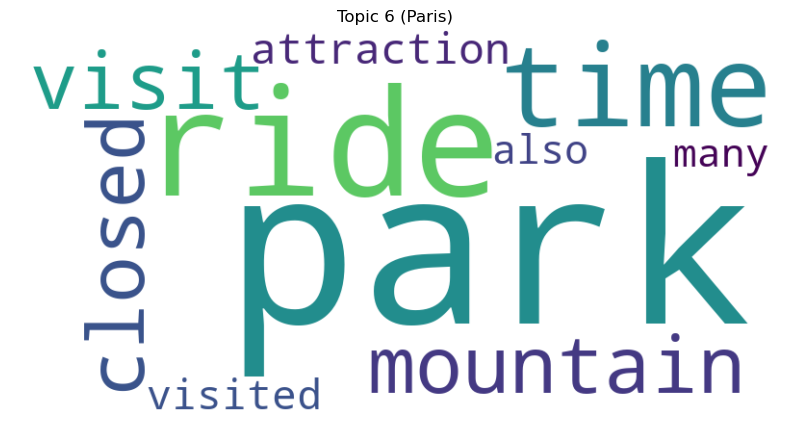

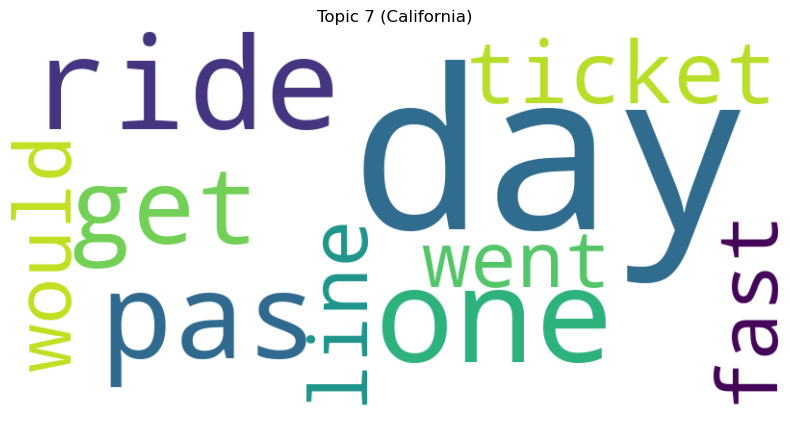

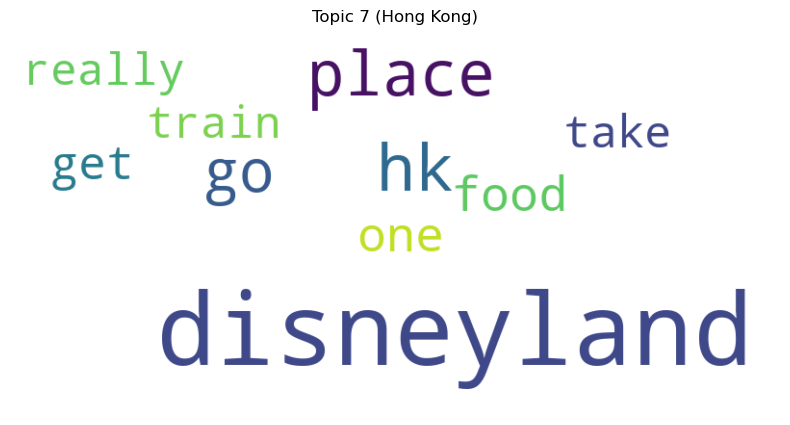

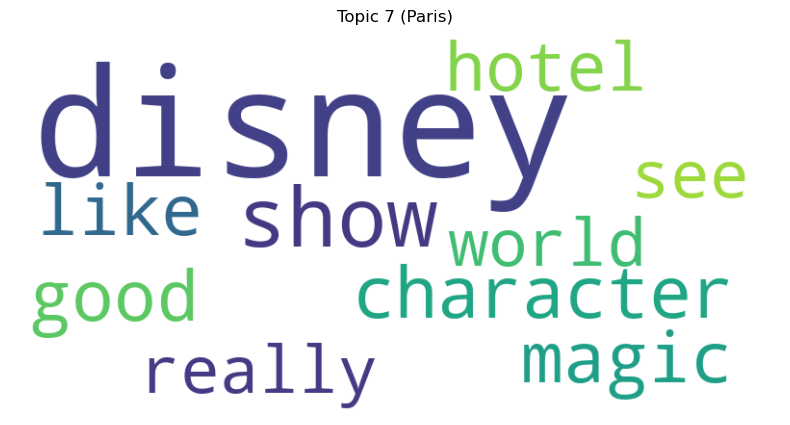

In [54]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionaries to store the top words for each topic for each branch.
nmf_topic_words_cali = {}
nmf_topic_words_hk = {}
nmf_topic_words_paris = {}

# Loop over topics (adjust the range to the number of topics you have)
for topic in range(7):  # For example, if you have 7 topics
    # Get top 10 words for each topic using NMF model's show_topic method.
    words_cali = dict(nmf_model_cali.show_topic(topic, 10))
    words_hk = dict(nmf_model_hk.show_topic(topic, 10))
    words_paris = dict(nmf_model_paris.show_topic(topic, 10))

    # Store just the word list if needed.
    nmf_topic_words_cali[f"Topic {topic+1}"] = list(words_cali.keys())
    nmf_topic_words_hk[f"Topic {topic+1}"] = list(words_hk.keys())
    nmf_topic_words_paris[f"Topic {topic+1}"] = list(words_paris.keys())

    # Generate and display word cloud for California.
    wordcloud_cali = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_cali)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_cali, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (California)")
    plt.show()

    # Generate and display word cloud for Hong Kong.
    wordcloud_hk = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_hk)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_hk, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (Hong Kong)")
    plt.show()

    # Generate and display word cloud for Paris.
    wordcloud_paris = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_paris)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_paris, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (Paris)")
    plt.show()


In [55]:
num_words = 10

# Print topics for each branch using the NMF model's print_topics method
topics_cali = nmf_model_cali.print_topics(num_words=num_words)
topics_hk = nmf_model_hk.print_topics(num_words=num_words)
topics_paris = nmf_model_paris.print_topics(num_words=num_words)

print("Topics for California:")
for topic in topics_cali:
    print(f"Topic {topic[0]}: {topic[1]}")

print("\nTopics for Hong Kong:")
for topic in topics_hk:
    print(f"Topic {topic[0]}: {topic[1]}")

print("\nTopics for Paris:")
for topic in topics_paris:
    print(f"Topic {topic[0]}: {topic[1]}")


Topics for California:
Topic 0: 0.048*"line" + 0.024*"ride" + 0.014*"kid" + 0.014*"long" + 0.013*"people" + 0.011*"wait" + 0.011*"minute" + 0.009*"park" + 0.009*"would" + 0.008*"go"
Topic 1: 0.069*"disney" + 0.019*"world" + 0.012*"get" + 0.010*"one" + 0.009*"like" + 0.007*"go" + 0.006*"people" + 0.006*"hotel" + 0.006*"experience" + 0.005*"much"
Topic 2: 0.066*"disneyland" + 0.015*"place" + 0.015*"year" + 0.008*"visit" + 0.008*"go" + 0.007*"like" + 0.007*"love" + 0.007*"great" + 0.006*"would" + 0.006*"fun"
Topic 3: 0.078*"time" + 0.021*"get" + 0.014*"go" + 0.011*"wait" + 0.008*"first" + 0.008*"great" + 0.008*"park" + 0.007*"year" + 0.007*"one" + 0.006*"good"
Topic 4: 0.115*"ride" + 0.031*"get" + 0.028*"fast" + 0.022*"pas" + 0.022*"mountain" + 0.011*"space" + 0.009*"go" + 0.009*"jones" + 0.009*"indiana" + 0.008*"show"
Topic 5: 0.132*"park" + 0.015*"disneyland" + 0.012*"california" + 0.010*"attraction" + 0.009*"adventure" + 0.008*"day" + 0.008*"visit" + 0.008*"ticket" + 0.007*"theme" + 0.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

tfidf_cali = tfidf_vectorizer.fit_transform(df_cali["cleaned_text"])
tfidf_hk = tfidf_vectorizer.fit_transform(df_hk["cleaned_text"])
tfidf_paris = tfidf_vectorizer.fit_transform(df_paris["cleaned_text"])


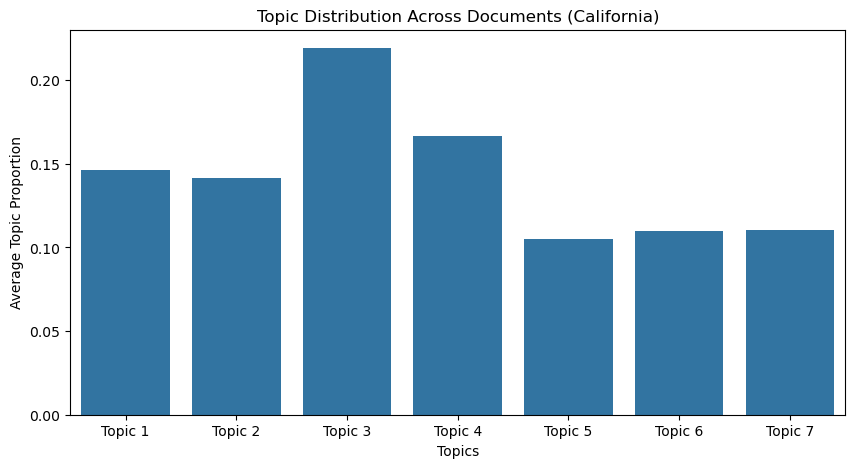

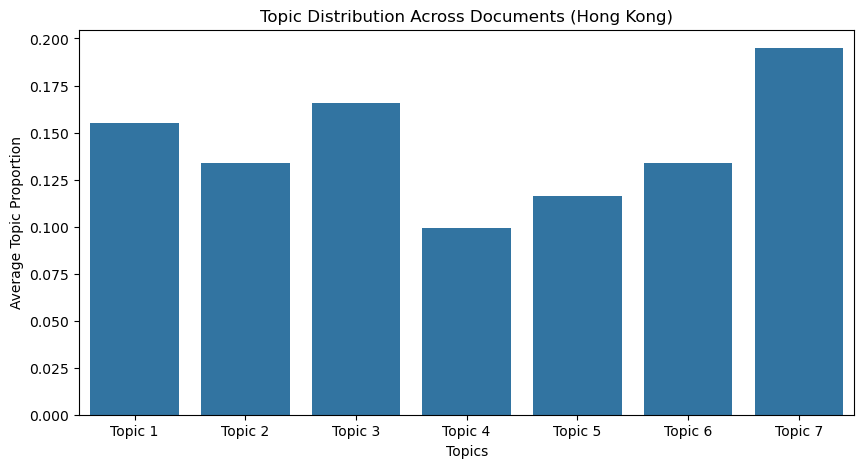

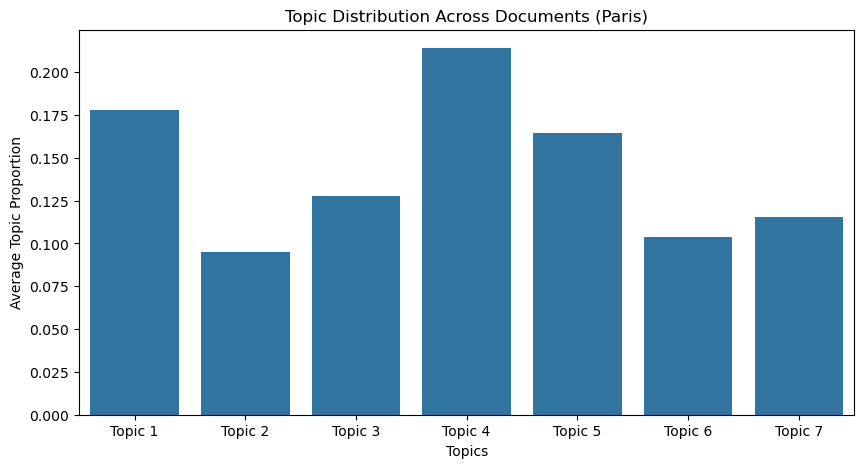

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_distributions(nmf_model, corpus, branch_name):
    """
    Plots the average topic distribution for a given branch.

    Args:
        nmf_model: The trained NMF model.
        corpus: The corpus of documents for the branch.
        branch_name: The name of the branch.
    """
    # Get the document-topic distribution (similar to transform in sklearn)
    doc_topic_dist = nmf_model[corpus]

    # Convert to dense array with consistent shape, padding with zeros for missing topics
    num_topics = nmf_model.num_topics
    doc_topic_dist_dense = np.zeros((len(corpus), num_topics))

    for doc_idx, doc_topics in enumerate(doc_topic_dist):
        for topic_idx, prob in doc_topics:
            doc_topic_dist_dense[doc_idx, topic_idx] = prob

    # Calculate the average topic proportion across all documents
    avg_topic_proportions = doc_topic_dist_dense.mean(axis=0)

    # Plot the average topic proportions using Seaborn
    plt.figure(figsize=(10, 5))
    sns.barplot(x=[f'Topic {i + 1}' for i in range(len(avg_topic_proportions))],
                y=avg_topic_proportions)
    plt.xlabel("Topics")
    plt.ylabel("Average Topic Proportion")
    plt.title(f"Topic Distribution Across Documents ({branch_name})")

    # Add this line to display the plot
    plt.show()

# Assuming you have tfidf_cali, tfidf_hk, tfidf_paris for each branch (create them using TfidfVectorizer)

# Visualize topic distribution for each branch using their respective NMF models and corpora.
plot_topic_distributions(nmf_model_cali, corpus_cali, "California")
plot_topic_distributions(nmf_model_hk, corpus_hk, "Hong Kong")
plot_topic_distributions(nmf_model_paris, corpus_paris, "Paris")

In [60]:
import pandas as pd

def get_topic_distribution(nmf_model, corpus):
    """
    Computes the topic distribution for each document using a Gensim-based NMF model.

    Args:
        nmf_model: The trained NMF model.
        corpus: The corpus of documents (in bag-of-words format) for the branch.

    Returns:
        A pandas DataFrame where each row corresponds to a document and each column to a topic.
    """
    topic_distributions = []
    for doc in corpus:
        # Get topic distribution for the document, ensuring every topic is included
        topic_dist = nmf_model.get_document_topics(doc, minimum_probability=0)
        topic_dist_dict = dict(topic_dist)
        # Ensure all topics (0 to num_topics-1) are present in the dictionary
        for i in range(nmf_model.num_topics):
            if i not in topic_dist_dict:
                topic_dist_dict[i] = 0
        topic_distributions.append(topic_dist_dict)

    # Convert list of dictionaries to a DataFrame
    df_topic_distributions = pd.DataFrame(topic_distributions)
    df_topic_distributions = df_topic_distributions.reindex(sorted(df_topic_distributions.columns), axis=1)
    return df_topic_distributions

# Example usage (assuming nmf_model_cali, nmf_model_hk, nmf_model_paris and their corresponding corpora are defined):
topic_distribution_cali = get_topic_distribution(nmf_model_cali, corpus_cali)
topic_distribution_hk = get_topic_distribution(nmf_model_hk, corpus_hk)
topic_distribution_paris = get_topic_distribution(nmf_model_paris, corpus_paris)

# Display the DataFrames
print("Topic Distribution for California:")
print(topic_distribution_cali)
print("\nTopic Distribution for Hong Kong:")
print(topic_distribution_hk)
print("\nTopic Distribution for Paris:")
print(topic_distribution_paris)


Topic Distribution for California:
              0         1         2         3         4         5         6
0      0.080693  0.041625  0.529024  0.124748  0.011910  0.211999  0.000000
1      0.000000  0.465803  0.046772  0.056410  0.003960  0.000000  0.427055
2      0.000000  0.000000  0.000000  0.510700  0.305033  0.000000  0.184267
3      0.129867  0.102578  0.045540  0.060448  0.597113  0.064454  0.000000
4      0.000000  0.016383  0.143212  0.026082  0.000000  0.000000  0.814322
...         ...       ...       ...       ...       ...       ...       ...
19401  0.251127  0.088889  0.136242  0.518719  0.000000  0.000374  0.004650
19402  0.541891  0.059658  0.000000  0.060195  0.196840  0.141415  0.000000
19403  0.786883  0.000000  0.035124  0.000000  0.000000  0.000000  0.177993
19404  0.082149  0.123907  0.758975  0.018165  0.007246  0.009559  0.000000
19405  0.062250  0.143223  0.017969  0.245703  0.324045  0.028049  0.178761

[19406 rows x 7 columns]

Topic Distribution for Hon

In [61]:
def display_topics(model, feature_names, no_top_words=10):
    """
    Prints the top words for each topic in the fitted model.
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx}: {' '.join(top_features)}")

In [64]:
topic_numbers = [5, 10, 15]  # You can add more, e.g. [5, 8, 10, 12, 15, 20]

for num_topics in topic_numbers:
    print("=" * 60)
    print(f"Testing with {num_topics} topics")
    print("=" * 60)


Testing with 5 topics
Testing with 10 topics
Testing with 15 topics


In [65]:
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf)
print(f"\n--- NMF with {num_topics} topics ---")
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), no_top_words=10)



--- NMF with 15 topics ---
Topic 0: frustrating guide family st real reading closing large included reservation
Topic 1: previous entire highlight waiting march try event filled highly reservation
Topic 2: drive wrong pizza frozen map picture pavilion watched smile looked
Topic 3: drop change waiting girl app picture fan looked true hyperspace
Topic 4: life im drop waiting smaller november travel smile hyperspace like
Topic 5: happen girl run filled making compare ask frustrating tidy general
Topic 6: normal rude souvenir lack thoroughly july run prepared comparison standard
Topic 7: tidy younger paint different youre manage dinner wife true son
Topic 8: photo friendly autopia open cigarette sign march pick manage run
Topic 9: pinocchio terrible believe waiting compare walk dinner run avoid pizza
Topic 10: later annoying run yr manage event girl luckily exactly smaller
Topic 11: dining wife spending spectacular european disneyland half thrill dinner thunder
Topic 12: man large grown t

In [66]:
# Get the feature names from the TF-IDF vectorizer (i.e. the words)
feature_names = tfidf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    """Print the top words for each topic from the NMF model."""
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        # Get indices of the top words for this topic
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[topic_idx] = top_features
        print(f"Topic {topic_idx}: {' '.join(top_features)}")
    return topics


## LSA

In [68]:
#train the LSA model
from gensim.models import LsiModel

def train_lsa(corpus, dictionary, num_topics=7):
    """
    Trains a Gensim-based LSA (Latent Semantic Analysis) model on the provided corpus and dictionary.

    :param corpus: Gensim corpus (list of (token_id, token_count) tuples).
    :param dictionary: Gensim dictionary mapping token_id -> token_string.
    :param num_topics: Number of topics for the LSA model.
    :return: Trained LsiModel.
    """
    lsa_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    return lsa_model

# Example usage:
# lsa_model_cali = train_lsa(corpus_cali, dictionary_cali, num_topics=7)


In [69]:
# Example usage for each branch (assuming you have created corpus_cali, dictionary_cali, etc.)
lsa_model_cali = train_lsa(corpus_cali, dictionary_cali, num_topics=7)
lsa_model_hk = train_lsa(corpus_hk, dictionary_hk, num_topics=7)
lsa_model_paris = train_lsa(corpus_paris, dictionary_paris, num_topics=7)


C:\Users\matth\anaconda3\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
C:\Users\matth\anaconda3\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
C:\Users\matth\anaconda3\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be r

In [71]:
from gensim.models import CoherenceModel

# Compute Coherence Score for an LSA model
def compute_coherence_lsa(lsa_model, tokenized_texts, dictionary):
    coherence_model = CoherenceModel(model=lsa_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Compute coherence for each branch using the cleaned tokenized texts.
# Assuming your cleaned texts are stored in a column "cleaned_text" and are space-separated tokens.
coherence_lsa_cali = compute_coherence_lsa(lsa_model_cali, [text.split() for text in df_cali["cleaned_text"]], dictionary_cali)
coherence_lsa_hk = compute_coherence_lsa(lsa_model_hk, [text.split() for text in df_hk["cleaned_text"]], dictionary_hk)
coherence_lsa_paris = compute_coherence_lsa(lsa_model_paris, [text.split() for text in df_paris["cleaned_text"]], dictionary_paris)

print(f'Coherence Score (LSA - California): {coherence_lsa_cali:.4f}')
print(f'Coherence Score (LSA - Hong Kong): {coherence_lsa_hk:.4f}')
print(f'Coherence Score (LSA - Paris): {coherence_lsa_paris:.4f}')


Coherence Score (LSA - California): 0.3577
Coherence Score (LSA - Hong Kong): 0.3496
Coherence Score (LSA - Paris): 0.3517


In [72]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_reconstruction_error(documents, num_topics=7, max_features=2000):
    """
    Computes the reconstruction error for an LSA model using TruncatedSVD.
    This error serves as a proxy for perplexity in probabilistic models.

    Args:
        documents (list): List of document texts.
        num_topics (int): Number of topics/components for LSA.
        max_features (int): Maximum number of features for the TF-IDF vectorizer.

    Returns:
        reconstruction_error (float): The Frobenius norm of the difference
                                        between the original TF-IDF matrix and its reconstruction.
    """
    # Create a TF-IDF matrix from the documents
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    # Train an LSA model using TruncatedSVD
    lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
    lsa_transformed = lsa_model.fit_transform(tfidf_matrix)

    # Reconstruct the TF-IDF matrix from the LSA components
    reconstructed_matrix = np.dot(lsa_transformed, lsa_model.components_)

    # Compute the reconstruction error using the Frobenius norm
    reconstruction_error = np.linalg.norm(tfidf_matrix - reconstructed_matrix, ord='fro')
    return reconstruction_error

# Example usage:
# Assuming your cleaned texts for each branch are in the DataFrame columns "cleaned_text"
documents_cali = df_cali["cleaned_text"].tolist()
documents_hk = df_hk["cleaned_text"].tolist()
documents_paris = df_paris["cleaned_text"].tolist()

error_cali = compute_reconstruction_error(documents_cali, num_topics=7, max_features=2000)
error_hk = compute_reconstruction_error(documents_hk, num_topics=7, max_features=2000)
error_paris = compute_reconstruction_error(documents_paris, num_topics=7, max_features=2000)

print(f"Reconstruction Error (California): {error_cali:.4f}")
print(f"Reconstruction Error (Hong Kong): {error_hk:.4f}")
print(f"Reconstruction Error (Paris): {error_paris:.4f}")


Reconstruction Error (California): 132.1329
Reconstruction Error (Hong Kong): 93.0944
Reconstruction Error (Paris): 110.2888


In [74]:
#visualize the California
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# --------- 1. Process Document-Topic Distributions ---------
# Get the document-topic distribution for each document
doc_topic_dist = lsa_model_cali[corpus_cali]  # each doc: list of (topic_id, score) pairs

num_topics = lsa_model_cali.num_topics
doc_topic_dist_dense = np.zeros((len(corpus_cali), num_topics))

# For each document, take the absolute score then normalize so that each document sums to 1.
for doc_idx, doc_topics in enumerate(doc_topic_dist):
    # Convert scores to non-negative values
    scores = np.array([abs(score) for _, score in doc_topics])
    topics = [topic for topic, _ in doc_topics]
    # Place scores in the proper positions
    for topic, score in zip(topics, scores):
        doc_topic_dist_dense[doc_idx, topic] = score
    # Normalize the row; if the row sums to 0, leave it as zeros.
    row_sum = doc_topic_dist_dense[doc_idx, :].sum()
    if row_sum > 0:
        doc_topic_dist_dense[doc_idx, :] /= row_sum

# --------- 2. Build the Topic-Term Matrix ---------
# Use lsa_model_cali.show_topics to get topics as (topic_id, [(word, weight), ...])
# We extract the weights (again taking absolute values) for all words in the dictionary.
vocab = list(dictionary_cali.values())
topic_term_matrix = np.zeros((num_topics, len(vocab)))

# Get topics with all words (formatted=False returns list of (word, weight) tuples)
topics = lsa_model_cali.show_topics(num_topics=num_topics, num_words=len(vocab), formatted=False)

for topic_idx, topic in topics:
    for word, weight in topic:
        try:
            term_idx = vocab.index(word)
            topic_term_matrix[topic_idx, term_idx] = abs(weight)
        except ValueError:
            continue
# Normalize each topic's word distribution to sum to 1
topic_term_matrix = topic_term_matrix / topic_term_matrix.sum(axis=1, keepdims=True)

# --------- 3. Compute Term Frequencies and Document Lengths ---------
term_frequency = np.zeros(len(vocab))
doc_lengths = []
for doc in corpus_cali:
    doc_len = 0
    for term_id, count in doc:
        term_frequency[term_id] += count
        doc_len += count
    doc_lengths.append(doc_len)

# --------- 4. Prepare and Display the Visualization ---------
lsa_vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_matrix,
    doc_topic_dists=doc_topic_dist_dense,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

pyLDAvis.enable_notebook()  # if using Jupyter Notebook
pyLDAvis.display(lsa_vis_data)


In [75]:
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# --------- 1. Process Document-Topic Distributions for Paris ---------
# Obtain the document-topic distributions from the LSA model.
doc_topic_dist = lsa_model_paris[corpus_paris]  # each document returns a list of (topic_id, score) tuples
num_topics = lsa_model_paris.num_topics
doc_topic_dist_dense = np.zeros((len(corpus_paris), num_topics))

# Convert scores (which may be negative) to non-negative values and normalize each document's distribution.
for doc_idx, doc_topics in enumerate(doc_topic_dist):
    scores = np.array([abs(score) for _, score in doc_topics])
    topics = [topic for topic, _ in doc_topics]
    for topic, score in zip(topics, scores):
        doc_topic_dist_dense[doc_idx, topic] = score
    row_sum = doc_topic_dist_dense[doc_idx, :].sum()
    if row_sum > 0:
        doc_topic_dist_dense[doc_idx, :] /= row_sum

# --------- 2. Build the Topic-Term Matrix for Paris ---------
# Extract the vocabulary from the Paris dictionary.
vocab = list(dictionary_paris.values())
topic_term_matrix = np.zeros((num_topics, len(vocab)))

# Use lsa_model_paris.show_topics to extract topic-term distributions.
# formatted=False returns a list of (word, weight) tuples.
topics = lsa_model_paris.show_topics(num_topics=num_topics, num_words=len(vocab), formatted=False)

for topic_idx, topic in topics:
    for word, weight in topic:
        try:
            term_idx = vocab.index(word)
            topic_term_matrix[topic_idx, term_idx] = abs(weight)
        except ValueError:
            continue

# Normalize each topic's word distribution so the probabilities sum to 1.
topic_term_matrix = topic_term_matrix / topic_term_matrix.sum(axis=1, keepdims=True)

# --------- 3. Compute Term Frequencies and Document Lengths for Paris ---------
term_frequency = np.zeros(len(vocab))
doc_lengths = []
for doc in corpus_paris:
    doc_len = 0
    for term_id, count in doc:
        term_frequency[term_id] += count
        doc_len += count
    doc_lengths.append(doc_len)

# --------- 4. Prepare and Display the Visualization for Paris ---------
lsa_vis_paris = pyLDAvis.prepare(
    topic_term_dists=topic_term_matrix,
    doc_topic_dists=doc_topic_dist_dense,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

pyLDAvis.enable_notebook()  # Enable notebook display if you're in a Jupyter environment
pyLDAvis.display(lsa_vis_paris)


In [76]:
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# --------- 1. Process Document-Topic Distributions for Hong Kong ---------
# Obtain the document-topic distributions from the LSA model.
doc_topic_dist = lsa_model_hk[corpus_hk]  # Each document returns a list of (topic_id, score) tuples
num_topics = lsa_model_hk.num_topics
doc_topic_dist_dense = np.zeros((len(corpus_hk), num_topics))

# Convert scores (which may be negative) to non-negative values and normalize each document's distribution.
for doc_idx, doc_topics in enumerate(doc_topic_dist):
    # Take absolute values of the scores
    scores = np.array([abs(score) for _, score in doc_topics])
    topics = [topic for topic, _ in doc_topics]
    for topic, score in zip(topics, scores):
        doc_topic_dist_dense[doc_idx, topic] = score
    # Normalize the document's topic vector so that the sum is 1.
    row_sum = doc_topic_dist_dense[doc_idx, :].sum()
    if row_sum > 0:
        doc_topic_dist_dense[doc_idx, :] /= row_sum

# --------- 2. Build the Topic-Term Matrix for Hong Kong ---------
# Extract the vocabulary from the Hong Kong dictionary.
vocab = list(dictionary_hk.values())
topic_term_matrix = np.zeros((num_topics, len(vocab)))

# Use lsa_model_hk.show_topics to extract topic-term distributions.
# formatted=False returns a list of (word, weight) tuples.
topics = lsa_model_hk.show_topics(num_topics=num_topics, num_words=len(vocab), formatted=False)

for topic_idx, topic in topics:
    for word, weight in topic:
        try:
            term_idx = vocab.index(word)
            topic_term_matrix[topic_idx, term_idx] = abs(weight)
        except ValueError:
            continue

# Normalize each topic's word distribution so that each row sums to 1.
topic_term_matrix = topic_term_matrix / topic_term_matrix.sum(axis=1, keepdims=True)

# --------- 3. Compute Term Frequencies and Document Lengths for Hong Kong ---------
term_frequency = np.zeros(len(vocab))
doc_lengths = []
for doc in corpus_hk:
    doc_len = 0
    for term_id, count in doc:
        term_frequency[term_id] += count
        doc_len += count
    doc_lengths.append(doc_len)

# --------- 4. Prepare and Display the Visualization for Hong Kong ---------
lsa_vis_hk = pyLDAvis.prepare(
    topic_term_dists=topic_term_matrix,
    doc_topic_dists=doc_topic_dist_dense,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

pyLDAvis.enable_notebook()  # Enable display if using a Jupyter Notebook
pyLDAvis.display(lsa_vis_hk)


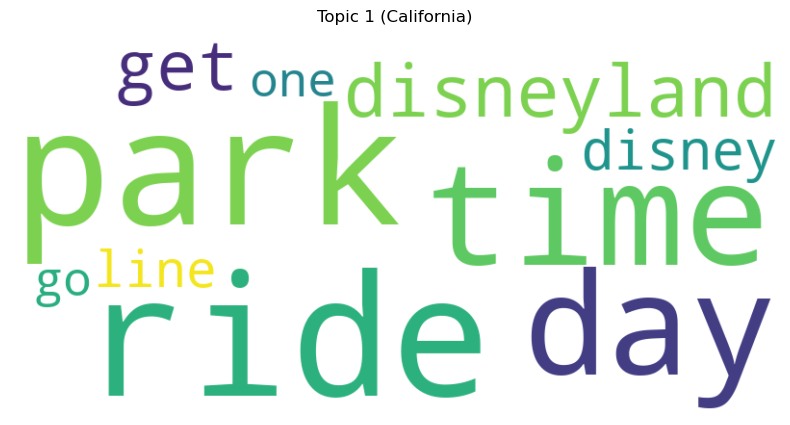

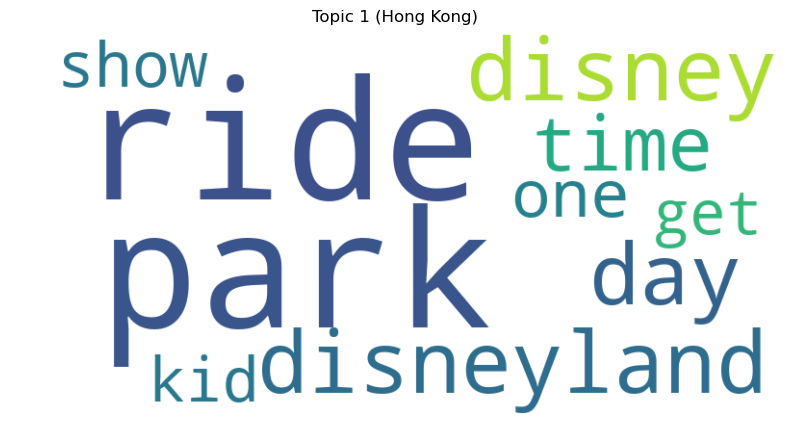

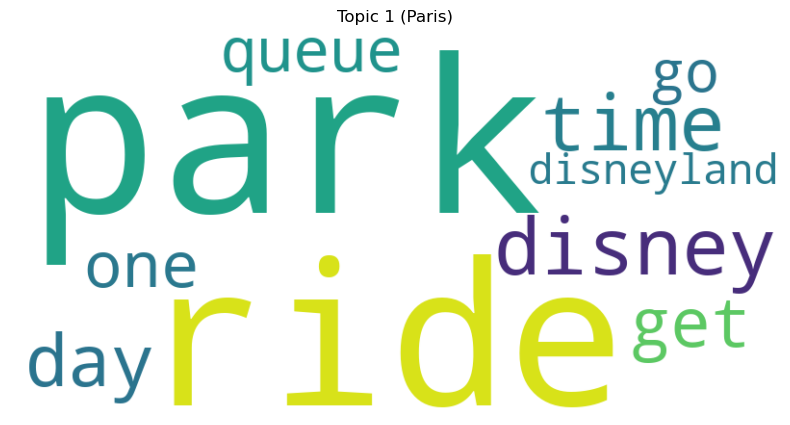

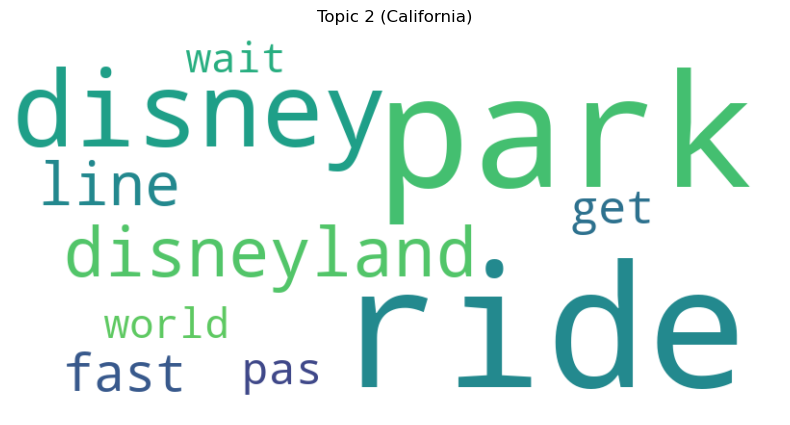

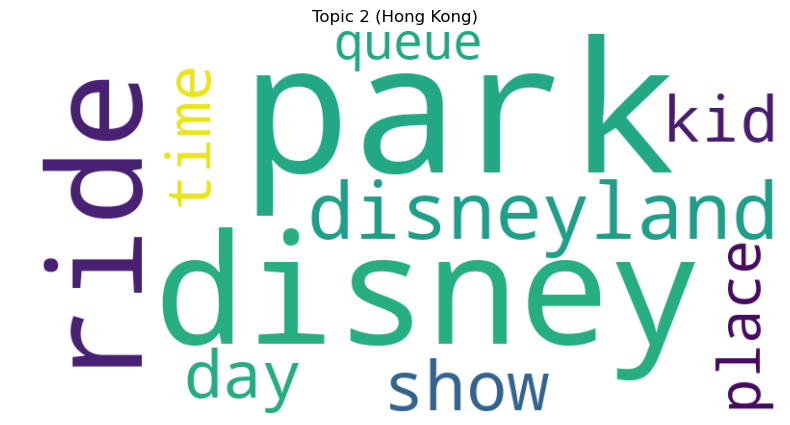

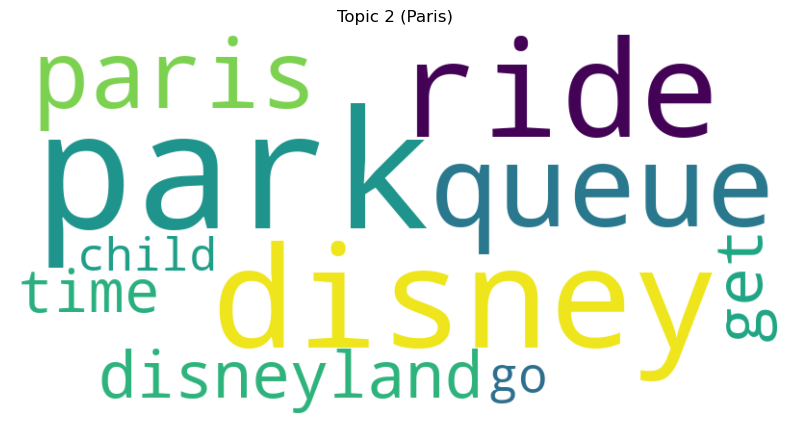

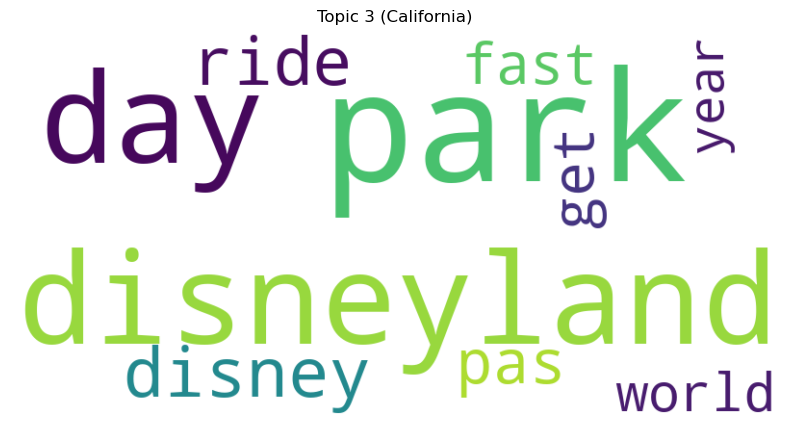

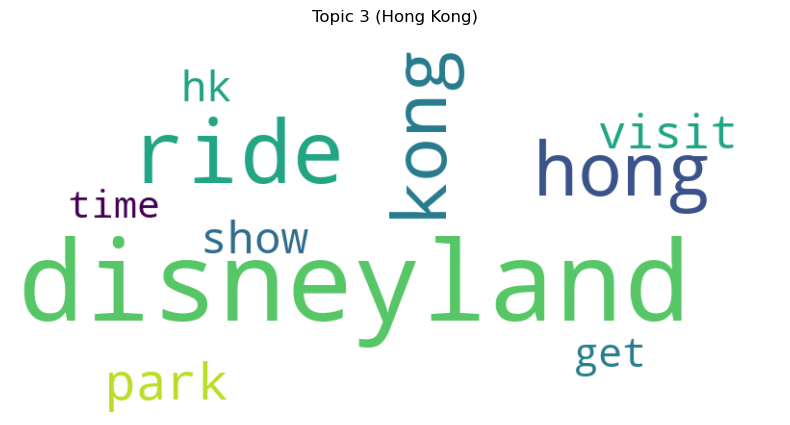

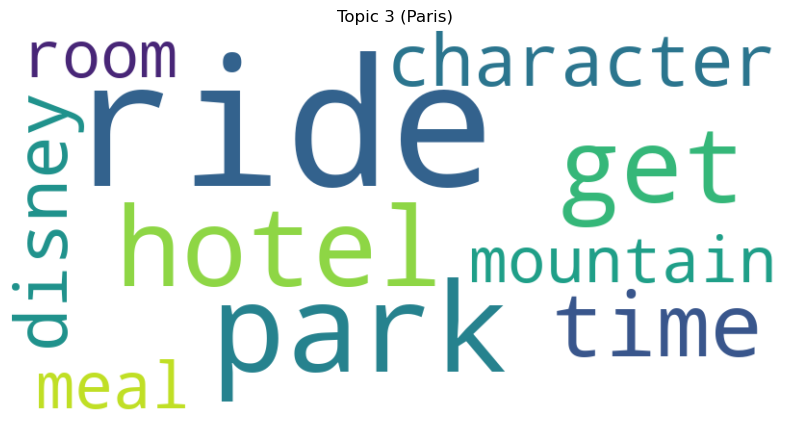

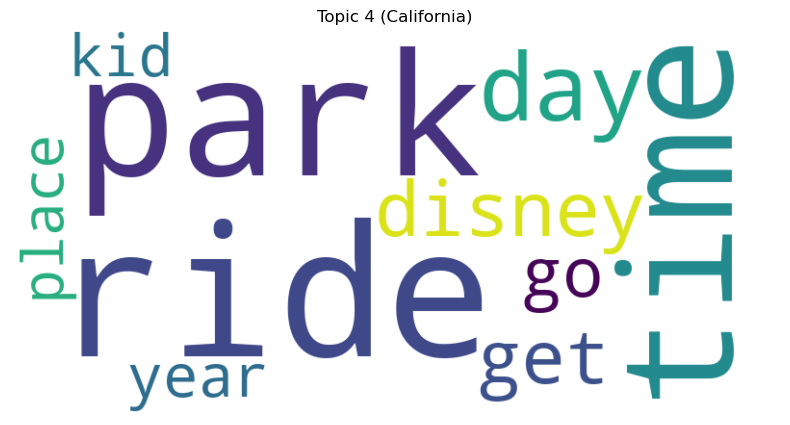

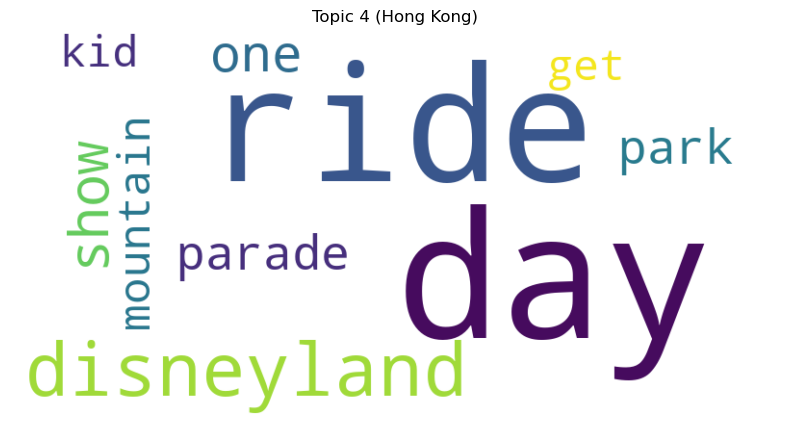

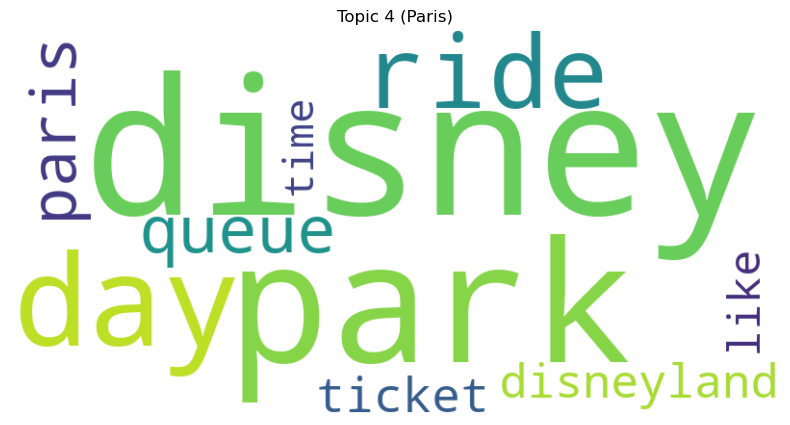

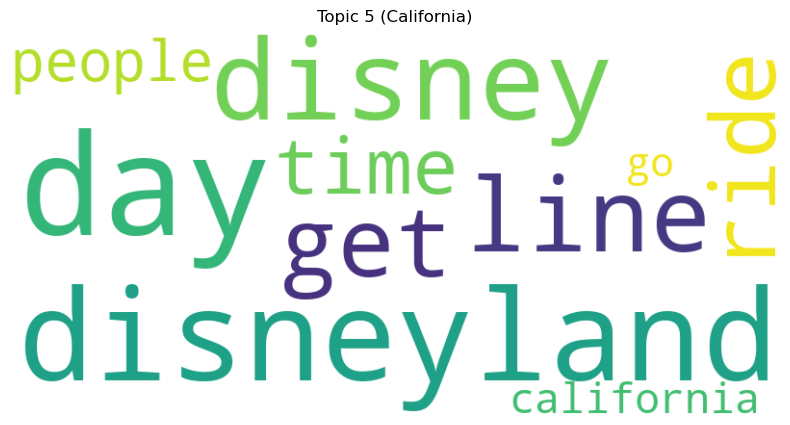

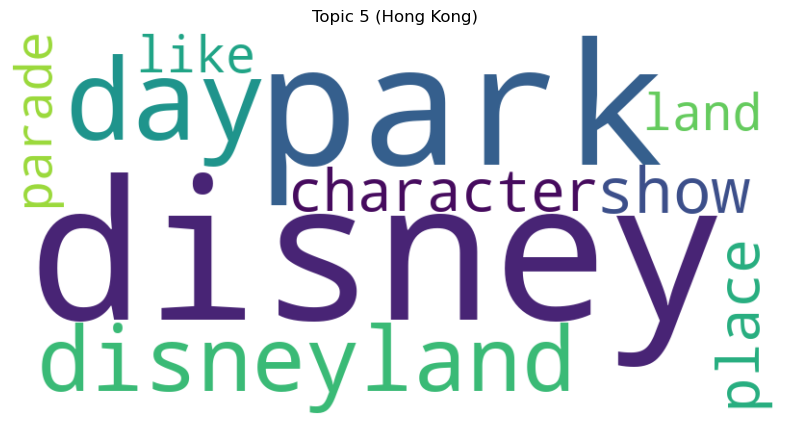

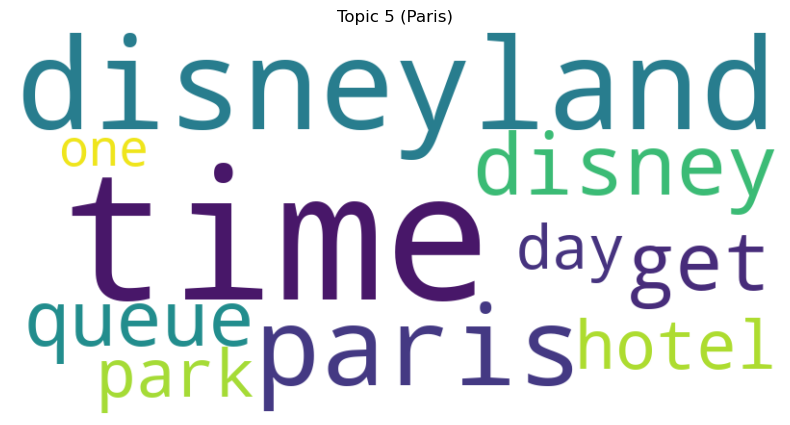

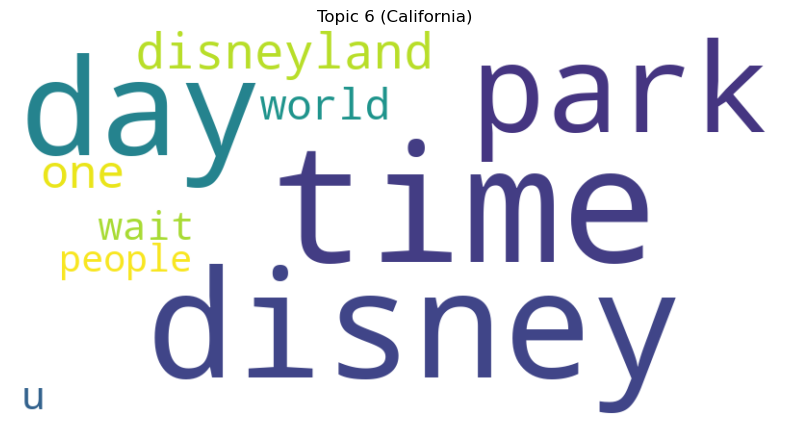

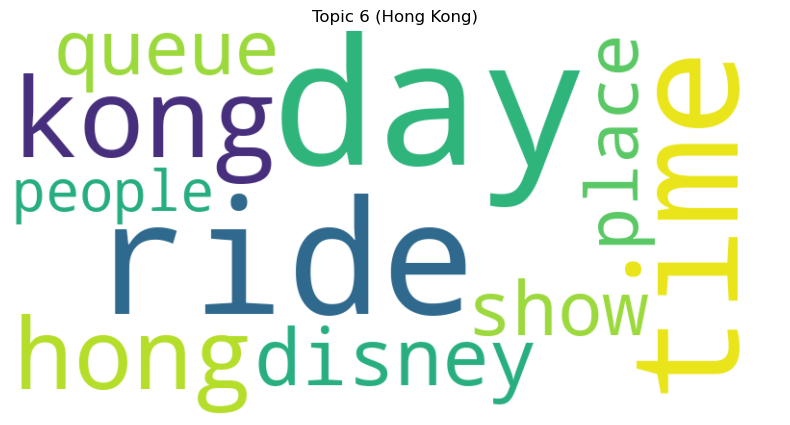

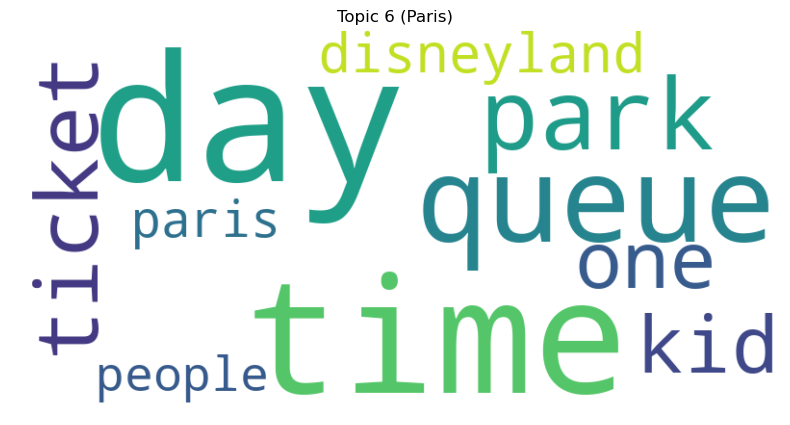

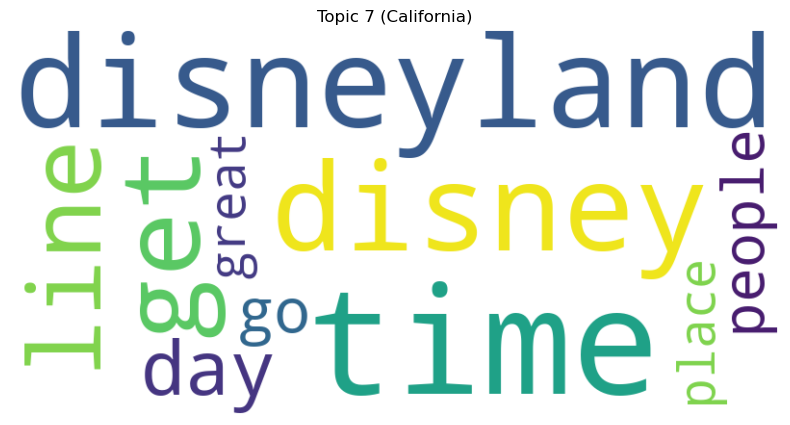

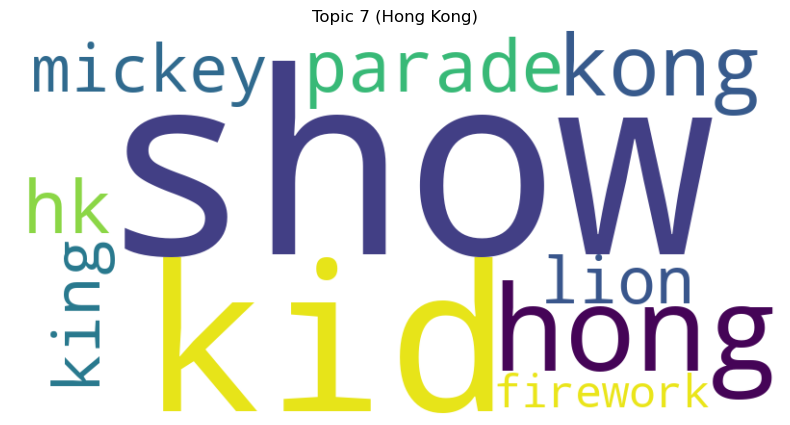

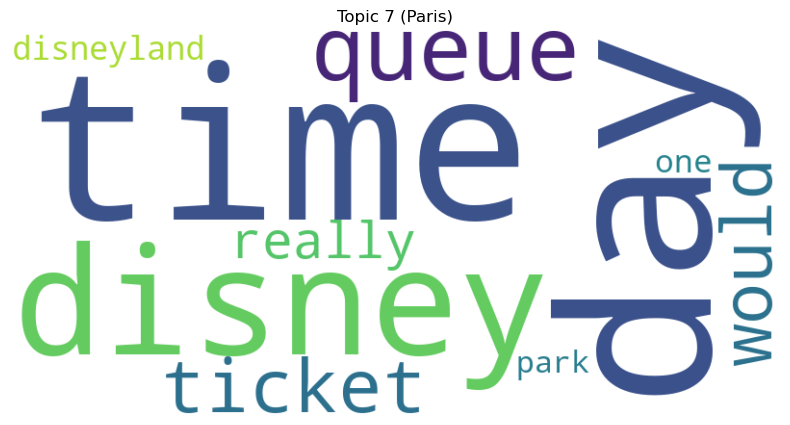

In [77]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionaries to store the top words for each topic for each branch.
lsa_topic_words_cali = {}
lsa_topic_words_hk = {}
lsa_topic_words_paris = {}

for topic in range(7):  # Adjust the range to the number of topics
    # For LSA, use show_topic. Take absolute values of weights to avoid negatives.
    words_cali = {word: abs(weight) for word, weight in lsa_model_cali.show_topic(topic, 10)}
    words_hk   = {word: abs(weight) for word, weight in lsa_model_hk.show_topic(topic, 10)}
    words_paris= {word: abs(weight) for word, weight in lsa_model_paris.show_topic(topic, 10)}

    lsa_topic_words_cali[f"Topic {topic+1}"] = list(words_cali.keys())
    lsa_topic_words_hk[f"Topic {topic+1}"]   = list(words_hk.keys())
    lsa_topic_words_paris[f"Topic {topic+1}"] = list(words_paris.keys())

    # Generate Word Cloud for each topic in California
    wordcloud_cali = WordCloud(width=800, height=400, background_color='white') \
                        .generate_from_frequencies(words_cali)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_cali, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (California)")
    plt.show()

    # Generate Word Cloud for each topic in Hong Kong
    wordcloud_hk = WordCloud(width=800, height=400, background_color='white') \
                        .generate_from_frequencies(words_hk)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_hk, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (Hong Kong)")
    plt.show()

    # Generate Word Cloud for each topic in Paris
    wordcloud_paris = WordCloud(width=800, height=400, background_color='white') \
                        .generate_from_frequencies(words_paris)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_paris, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (Paris)")
    plt.show()


In [89]:
num_words = 10

# Print topics for each branch using LSA models
topics_cali = lsa_model_cali.print_topics(num_topics=lsa_model_cali.num_topics, num_words=num_words)
topics_hk = lsa_model_hk.print_topics(num_topics=lsa_model_hk.num_topics, num_words=num_words)
topics_paris = lsa_model_paris.print_topics(num_topics=lsa_model_paris.num_topics, num_words=num_words)

print("LSA Topics for California:")
for topic in topics_cali:
    print(f"Topic {topic[0]}: {topic[1]}")

print("\nLSA Topics for Hong Kong:")
for topic in topics_hk:
    print(f"Topic {topic[0]}: {topic[1]}")

print("\nLSA Topics for Paris:")
for topic in topics_paris:
    print(f"Topic {topic[0]}: {topic[1]}")


LSA Topics for California:
Topic 0: 0.380*"ride" + 0.355*"park" + 0.276*"time" + 0.265*"day" + 0.231*"disneyland" + 0.205*"get" + 0.195*"disney" + 0.169*"line" + 0.148*"one" + 0.148*"go"
Topic 1: 0.570*"ride" + -0.485*"park" + -0.309*"disney" + -0.301*"disneyland" + 0.223*"line" + 0.164*"fast" + 0.135*"get" + 0.117*"pas" + 0.103*"wait" + -0.103*"world"
Topic 2: -0.470*"park" + 0.449*"disneyland" + -0.433*"day" + 0.240*"disney" + 0.227*"ride" + -0.185*"pas" + -0.165*"get" + -0.158*"fast" + 0.136*"world" + 0.114*"year"
Topic 3: -0.540*"ride" + -0.467*"park" + 0.386*"time" + 0.290*"day" + -0.182*"disney" + 0.171*"get" + 0.145*"go" + 0.102*"year" + 0.100*"kid" + 0.098*"place"
Topic 4: 0.557*"day" + 0.458*"disneyland" + -0.345*"disney" + -0.287*"line" + -0.253*"get" + 0.222*"ride" + -0.154*"time" + -0.130*"people" + 0.090*"california" + -0.083*"go"
Topic 5: -0.577*"time" + 0.484*"disney" + 0.390*"day" + -0.329*"park" + -0.150*"disneyland" + 0.136*"one" + 0.112*"world" + 0.090*"u" + -0.089*"

C:\Users\matth\AppData\Local\Temp\ipykernel_28400\1962312898.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


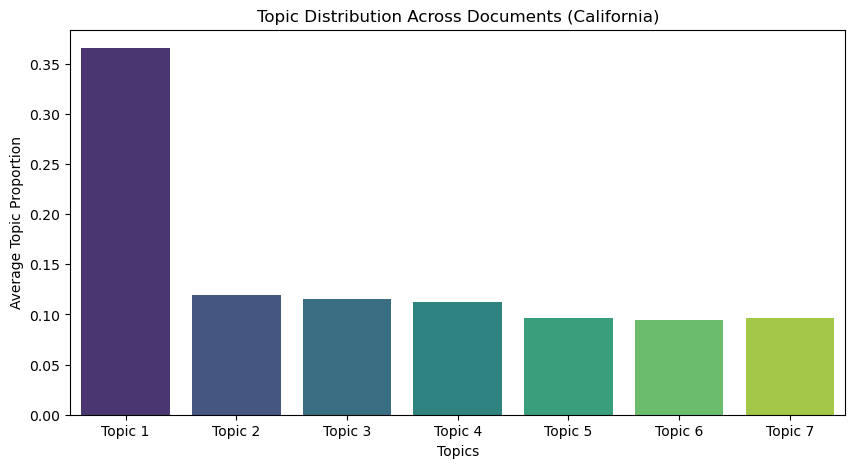

C:\Users\matth\AppData\Local\Temp\ipykernel_28400\1962312898.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


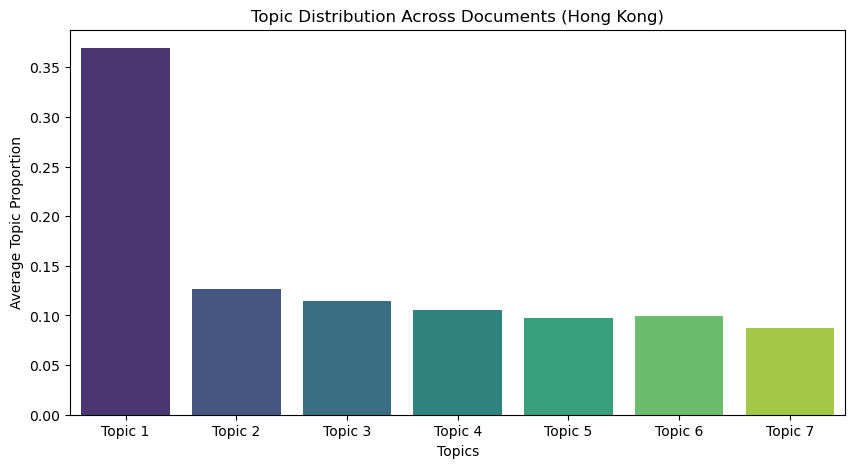

C:\Users\matth\AppData\Local\Temp\ipykernel_28400\1962312898.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


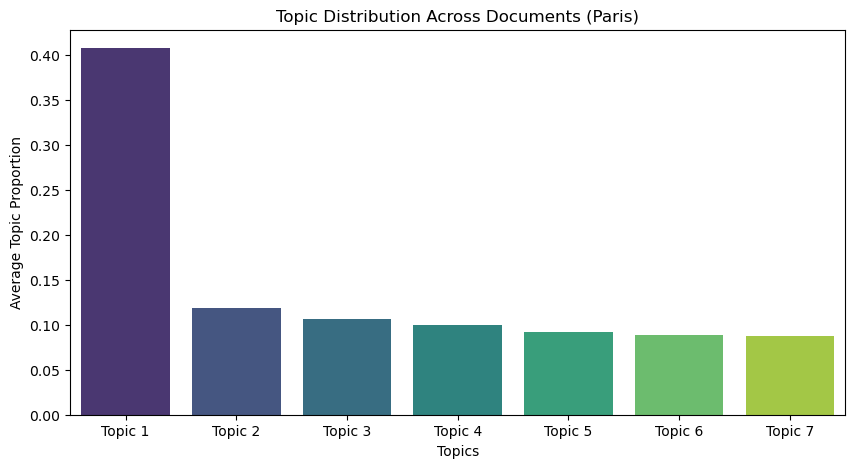

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_distributions(lsa_model, corpus, branch_name):
    """
    Plots the average topic distribution for an LSA model with a custom color palette.

    Args:
        lsa_model: The trained LSA model (Gensim LsiModel).
        corpus: The corpus (list of documents in bag-of-words format).
        branch_name: Name of the branch (for plot title).
    """
    doc_topic_distributions = []

    for doc in corpus:
        # Get topic scores for the document; each element is (topic_id, score)
        topic_scores = lsa_model[doc]
        distribution = np.zeros(lsa_model.num_topics)

        # Convert scores to non-negative values and assign to the correct topic indices
        for topic_id, score in topic_scores:
            distribution[topic_id] = abs(score)

        # Normalize the distribution so that it sums to 1 (if non-zero)
        if distribution.sum() > 0:
            distribution = distribution / distribution.sum()

        doc_topic_distributions.append(distribution)

    # Compute the average topic proportions across documents
    topic_proportions = np.array(doc_topic_distributions)
    avg_topic_proportions = topic_proportions.mean(axis=0)

    # Plot with a custom color palette (using 'viridis' palette as an example)
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=[f'Topic {i+1}' for i in range(len(avg_topic_proportions))],
        y=avg_topic_proportions,
        palette=sns.color_palette("viridis", len(avg_topic_proportions))
    )
    plt.xlabel("Topics")
    plt.ylabel("Average Topic Proportion")
    plt.title(f"Topic Distribution Across Documents ({branch_name})")
    plt.show()

# Example usage:
plot_topic_distributions(lsa_model_cali, corpus_cali, "California")
plot_topic_distributions(lsa_model_hk, corpus_hk, "Hong Kong")
plot_topic_distributions(lsa_model_paris, corpus_paris, "Paris")


In [92]:
import numpy as np
import pandas as pd

def get_topic_distribution_lsa(lsa_model, corpus):
    """
    Computes the topic distribution for each document using a Gensim LSA (LsiModel).
    Since LSA scores can be negative, this function takes their absolute values
    and normalizes each document's topic distribution to sum to 1.

    Args:
        lsa_model: Trained LSA model (Gensim LsiModel).
        corpus: Gensim corpus (list of (token_id, token_count) tuples).

    Returns:
        A pandas DataFrame where each row corresponds to a document and each column to a topic.
    """
    topic_distributions = []
    for doc in corpus:
        # Get topic scores (list of (topic_id, score) tuples)
        topic_scores = lsa_model[doc]
        # Initialize a zero vector for the document with length equal to number of topics
        distribution = np.zeros(lsa_model.num_topics)
        for topic_id, score in topic_scores:
            distribution[topic_id] = abs(score)
        # Normalize the distribution if the sum is nonzero
        if distribution.sum() > 0:
            distribution = distribution / distribution.sum()
        # Convert to dictionary with all topics (filling in 0 if missing)
        topic_dist_dict = {i: distribution[i] for i in range(lsa_model.num_topics)}
        topic_distributions.append(topic_dist_dict)

    # Create and return a DataFrame with topics in sorted order.
    df_topic_distributions = pd.DataFrame(topic_distributions)
    df_topic_distributions = df_topic_distributions.reindex(sorted(df_topic_distributions.columns), axis=1)
    return df_topic_distributions

# Example usage (assuming lsa_model_cali, lsa_model_hk, lsa_model_paris and their corresponding corpora are defined):
topic_distribution_cali = get_topic_distribution_lsa(lsa_model_cali, corpus_cali)
topic_distribution_hk   = get_topic_distribution_lsa(lsa_model_hk, corpus_hk)
topic_distribution_paris= get_topic_distribution_lsa(lsa_model_paris, corpus_paris)

print("Topic Distribution for California:")
print(topic_distribution_cali.head())
print("\nTopic Distribution for Hong Kong:")
print(topic_distribution_hk.head())
print("\nTopic Distribution for Paris:")
print(topic_distribution_paris.head())


Topic Distribution for California:
          0         1         2         3         4         5         6
0  0.337149  0.199769  0.051127  0.069074  0.002006  0.085302  0.255574
1  0.316132  0.055813  0.050213  0.124954  0.046450  0.226015  0.180424
2  0.311437  0.198650  0.017754  0.049997  0.072327  0.131226  0.218609
3  0.372277  0.237219  0.104899  0.197602  0.031578  0.015419  0.041007
4  0.228750  0.006123  0.153345  0.179222  0.185177  0.176026  0.071357

Topic Distribution for Hong Kong:
          0         1         2         3         4         5         6
0  0.316755  0.110344  0.241055  0.054197  0.043537  0.187113  0.046999
1  0.385549  0.156903  0.067206  0.036910  0.091293  0.190580  0.071559
2  0.491159  0.029718  0.121881  0.046828  0.144225  0.153416  0.012772
3  0.323466  0.003131  0.235812  0.051999  0.098500  0.118203  0.168890
4  0.331239  0.081045  0.407519  0.079038  0.008323  0.039192  0.053644

Topic Distribution for Paris:
          0         1         2    

## Analyze and Review

In [125]:
from gensim.models.coherencemodel import CoherenceModel

coherence_lda_cali = CoherenceModel(model=lda_model_cali, texts=[text.split() for text in df_cali["cleaned_text"]], dictionary=dictionary_cali, coherence='c_v').get_coherence()
coherence_lsa_cali = CoherenceModel(model=lsa_model_cali, texts=[text.split() for text in df_cali["cleaned_text"]], dictionary=dictionary_cali, coherence='c_v').get_coherence()
coherence_nmf_cali = CoherenceModel(model=nmf_model_cali, texts=[text.split() for text in df_cali["cleaned_text"]], dictionary=dictionary_cali, coherence='c_v').get_coherence()

print(f"LDA Coherence: {coherence_lda_cali}")
print(f"LSA Coherence: {coherence_lsa_cali}")
print(f"NMF Coherence: {coherence_nmf_cali}")

LDA Coherence: 0.4793197278629873
LSA Coherence: 0.3576936749714958
NMF Coherence: 0.3571018634249281


In [126]:
coherence_lda_hk = CoherenceModel(model=lda_model_hk, texts=[text.split() for text in df_hk["cleaned_text"]], dictionary=dictionary_hk, coherence='c_v').get_coherence()
coherence_lsa_hk = CoherenceModel(model=lsa_model_hk, texts=[text.split() for text in df_hk["cleaned_text"]], dictionary=dictionary_hk, coherence='c_v').get_coherence()
coherence_nmf_hk = CoherenceModel(model=nmf_model_hk, texts=[text.split() for text in df_hk["cleaned_text"]], dictionary=dictionary_hk, coherence='c_v').get_coherence()

print(f"LDA Coherence: {coherence_lda_hk}")
print(f"LSA Coherence: {coherence_lsa_hk}")
print(f"NMF Coherence: {coherence_nmf_hk}")

LDA Coherence: 0.4717277823014841
LSA Coherence: 0.34957931696615124
NMF Coherence: 0.33418434462054325


In [127]:
coherence_lda_paris = CoherenceModel(model=lda_model_paris, texts=[text.split() for text in df_paris["cleaned_text"]], dictionary=dictionary_paris, coherence='c_v').get_coherence()
coherence_lsa_paris = CoherenceModel(model=lsa_model_paris, texts=[text.split() for text in df_paris["cleaned_text"]], dictionary=dictionary_paris, coherence='c_v').get_coherence()
coherence_nmf_paris = CoherenceModel(model=nmf_model_paris, texts=[text.split() for text in df_paris["cleaned_text"]], dictionary=dictionary_paris, coherence='c_v').get_coherence()

print(f"LDA Coherence: {coherence_lda_paris}")
print(f"LSA Coherence: {coherence_lsa_paris}")
print(f"NMF Coherence: {coherence_nmf_paris}")

LDA Coherence: 0.4588651888372753
LSA Coherence: 0.35168556544996543
NMF Coherence: 0.32726564825339693


In [149]:
# Print top words for each topic
for i, topic in lda_model_cali.show_topics(num_topics=7, num_words=10, formatted=False):
    print(f"Topic {i+1}: {', '.join([word[0] for word in topic])}")

Topic 1: mountain, pirate, jones, space, indiana, star, haunted, tour, mansion, caribbean
Topic 2: ride, day, line, wait, time, went, minute, got, fast, hour
Topic 3: u, member, cast, told, people, could, got, employee, said, would
Topic 4: disney, park, disneyland, world, california, attraction, like, better, magic, much
Topic 5: christmas, halloween, party, decoration, holiday, decorated, mansion, haunted, event, trick
Topic 6: disneyland, time, great, place, year, kid, fun, go, love, family
Topic 7: park, get, day, time, line, ride, one, go, pas, people


In [169]:
print("Topic 1: Attraction Themes")
print("Topic 2: Ride Wait Times")
print("Topic 3: Staff Interactions")
print("Topic 4: Park Overview")
print("Topic 5: Holiday and Seasonal Events")
print("Topic 6: Family Fun and Experiences")
print("Topic 7: Park Logistics")

Topic 1: Attraction Themes
Topic 2: Ride Wait Times
Topic 3: Staff Interactions
Topic 4: Park Overview
Topic 5: Holiday and Seasonal Events
Topic 6: Family Fun and Experiences
Topic 7: Park Logistics


In [167]:
# Print top words for each topic
for i, topic in lda_model_hk.show_topics(num_topics=7, num_words=10, formatted=False):
    print(f"Topic {i+1}: {', '.join([word[0] for word in topic])}")

Topic 1: ticket, food, people, disneyland, water, hot, get, queue, line, bring
Topic 2: place, kid, visit, family, enjoy, child, hongkong, adult, dream, childhood
Topic 3: park, disney, disneyland, ride, hong, kong, day, one, small, great
Topic 4: ride, day, time, show, disneyland, kid, parade, firework, place, character
Topic 5: kong, hong, disneyland, hkg, na, euro, los, wan, angeles, anniversary
Topic 6: happiest, n, earth, universal, studio, singapore, smoke, candy, cotton, amaze
Topic 7: mainlanders, maxim, dancer, varied, serious, flash, kiddie, frequently, mango, nut


In [171]:
print("Topic 1: Guest Essentials and Planning")
print("Topic 2: Family Fun and Experiences")
print("Topic 3: General Info")
print("Topic 4: Attractions")
print("Topic 5: Comparison to Other Parks")
print("Topic 6: Experiences")
print("Topic 7: Entertainment")

Topic 1: Guest Essentials and Planning
Topic 2: Family Fun and Experiences
Topic 3: General Info
Topic 4: Attractions
Topic 5: Comparison to Other Parks
Topic 6: Experiences
Topic 7: Entertainment


In [165]:
# Print top words for each topic
for i, topic in lda_model_paris.show_topics(num_topics=7, num_words=10, formatted=False):
    print(f"Topic {i+1}: {', '.join([word[0] for word in topic])}")

Topic 1: character, princess, buzz, people, meet, mountain, child, pan, peter, ride
Topic 2: show, great, parade, amazing, magical, time, loved, year, place, disney
Topic 3: hotel, meal, breakfast, stayed, room, euro, disney, village, night, restaurant
Topic 4: staff, u, service, told, would, people, could, rude, asked, customer
Topic 5: noted, hint, gang, elevator, cat, operated, obsessed, definetely, lille, bonfire
Topic 6: park, ride, time, day, get, disney, queue, one, go, food
Topic 7: disney, park, paris, disneyland, florida, like, mountain, ride, world, attraction


In [173]:
print("Topic 1: Character Encounters")
print("Topic 2: Entertainment")
print("Topic 3: Hotels and Dining")
print("Topic 4: Staff Interactions")
print("Topic 5: Experiences")
print("Topic 6: Ride Wait Times")
print("Topic 7: Comparison to Other Parks")

Topic 1: Character Encounters
Topic 2: Entertainment
Topic 3: Hotels and Dining
Topic 4: Staff Interactions
Topic 5: Experiences
Topic 6: Ride Wait Times
Topic 7: Comparison to Other Parks
